# DÉTECTION DE PNEUMONIE PAR DEEP LEARNING SUR RADIOGRAPHIES THORACIQUES PÉDIATRIQUES

### IMPORTATION DES BIBLIOTHÈQUES

In [2]:
# Configuration GPU (AVANT tous les imports TensorFlow/Keras)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow et verification GPU
import tensorflow as tf

print("=" * 60)
print("CONFIGURATION GPU")
print("=" * 60)

# Verifier GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"\nGPU DETECTE : {len(gpus)} GPU(s) disponible(s)")
    try:
        # Memory growth (allocation dynamique)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"   - {gpu.name} : Memory growth active")
        
        print(f"\nInformations GPU:")
        print(f"   - TensorFlow version : {tf.__version__}")
        print(f"   - Built with CUDA    : {tf.test.is_built_with_cuda()}")
        print(f"   - GPU disponible     : {tf.test.is_gpu_available()}")
        
    except RuntimeError as e:
        print(f"\nErreur GPU : {e}")
else:
    print("\nAUCUN GPU DETECTE - Utilisation du CPU")

print("=" * 60 + "\n")

# Callbacks Keras pour l'entrainement
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Modeles et couches Keras/TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image

# Bibliotheques de traitement d'images
import cv2
import imghdr
from PIL import Image

# Bibliotheques de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Calculs numeriques et manipulation de donnees
import numpy as np
import pandas as pd

# Metriques d'evaluation pour la classification
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Tous les imports sont charges avec succes!")

CONFIGURATION GPU

GPU DETECTE : 1 GPU(s) disponible(s)
   - /physical_device:GPU:0 : Memory growth active

Informations GPU:
   - TensorFlow version : 2.10.1
   - Built with CUDA    : True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
   - GPU disponible     : True

Tous les imports sont charges avec succes!


## CONFIGURATION DES CHEMINS ET ANALYSE DU DATASET

In [3]:
# Configuration des chemins
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# Dossier pour sauvegarder les modeles
model_save_dir = 'models'
os.makedirs(model_save_dir, exist_ok=True)

print("=" * 60)
print("ANALYSE DU DATASET")
print("=" * 60)

# Fonction pour compter les images
def count_images(directory):
    normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal, pneumonia

# Comptage
train_normal, train_pneumonia = count_images(train_dir)
test_normal, test_pneumonia = count_images(test_dir)
val_normal, val_pneumonia = count_images(val_dir)

# Affichage
print(f"\nENSEMBLE D'ENTRAINEMENT (TRAIN):")
print(f"   - Images NORMAL     : {train_normal}")
print(f"   - Images PNEUMONIA  : {train_pneumonia}")
print(f"   - Total             : {train_normal + train_pneumonia}")
print(f"   - Ratio (P:N)       : {train_pneumonia/train_normal:.2f}:1")

print(f"\nENSEMBLE DE TEST:")
print(f"   - Images NORMAL     : {test_normal}")
print(f"   - Images PNEUMONIA  : {test_pneumonia}")
print(f"   - Total             : {test_normal + test_pneumonia}")
print(f"   - Ratio (P:N)       : {test_pneumonia/test_normal:.2f}:1")

print(f"\nENSEMBLE DE VALIDATION:")
print(f"   - Images NORMAL     : {val_normal}")
print(f"   - Images PNEUMONIA  : {val_pneumonia}")
print(f"   - Total             : {val_normal + val_pneumonia}")

ANALYSE DU DATASET

ENSEMBLE D'ENTRAINEMENT (TRAIN):
   - Images NORMAL     : 1341
   - Images PNEUMONIA  : 3875
   - Total             : 5216
   - Ratio (P:N)       : 2.89:1

ENSEMBLE DE TEST:
   - Images NORMAL     : 234
   - Images PNEUMONIA  : 390
   - Total             : 624
   - Ratio (P:N)       : 1.67:1

ENSEMBLE DE VALIDATION:
   - Images NORMAL     : 8
   - Images PNEUMONIA  : 8
   - Total             : 16


# VISUALISATION DES DONNEES 


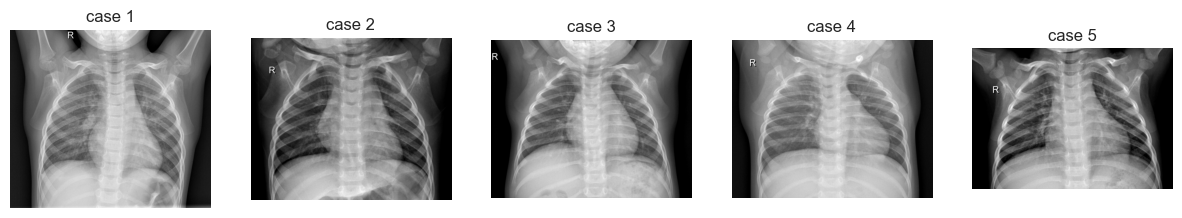

In [54]:
category = 'NORMAL'  

# Get a list of image filenames in the specified category
image_filenames = [f for f in os.listdir(os.path.join(train_dir, category)) if f.endswith('.jpeg')]

# Visualize multiple images
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i in range(min(5, len(image_filenames))):  # Display up to 5 images
    image_path = os.path.join(train_dir, category, image_filenames[i])
    image = cv2.imread(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f'case {i + 1}')
    plt.axis('off')

plt.show()

Cas Unhealthy

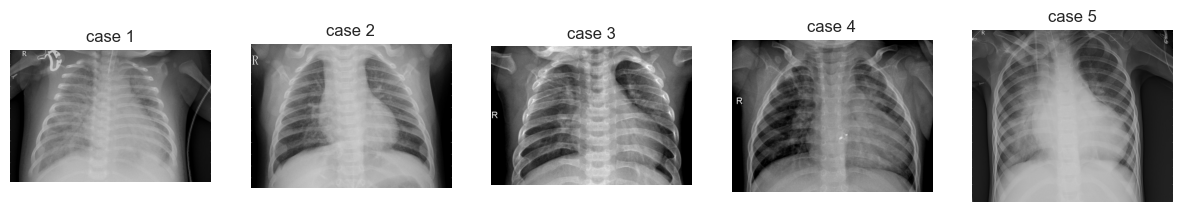

In [22]:
category = 'PNEUMONIA'  
# Get a list of image filenames in the specified category
image_filenames = [f for f in os.listdir(os.path.join(train_dir, category)) if f.endswith('.jpeg')]

# Visualize multiple images
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i in range(min(5, len(image_filenames))):  # Display up to 5 images
    image_path = os.path.join(train_dir, category, image_filenames[i])
    image = cv2.imread(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f'case {i + 1}')
    plt.axis('off')

plt.show()

# AUGMENTATION DES DONNÉES (DATA AUGMENTATION)

**⚠️ Le dataset est DÉSÉQUILIBRÉ**


Pour augmenter le nombre d'exemples d'entraînement et équilibrer les classes,
nous utilisons l'AUGMENTATION DE DONNÉES avec les transformations suivantes :
1. Rotation aléatoire de ±30 degrés
2. Zoom aléatoire de 20%
3. Décalage horizontal de 10% de la largeur
4. Décalage vertical de 10% de la hauteur
µ5. Retournement horizontal aléatoire

CONFIGURATION DE L'AUGMENTATION DES DONNEES
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

PARAMETRES D'ENTRAINEMENT:
   - Steps per epoch       : 163
   - Validation steps      : 19
   - Data augmentation     : ACTIVEE
   - Class weights         : NON (data augmentation utilisee)

Visualisation de l'augmentation des donnees...


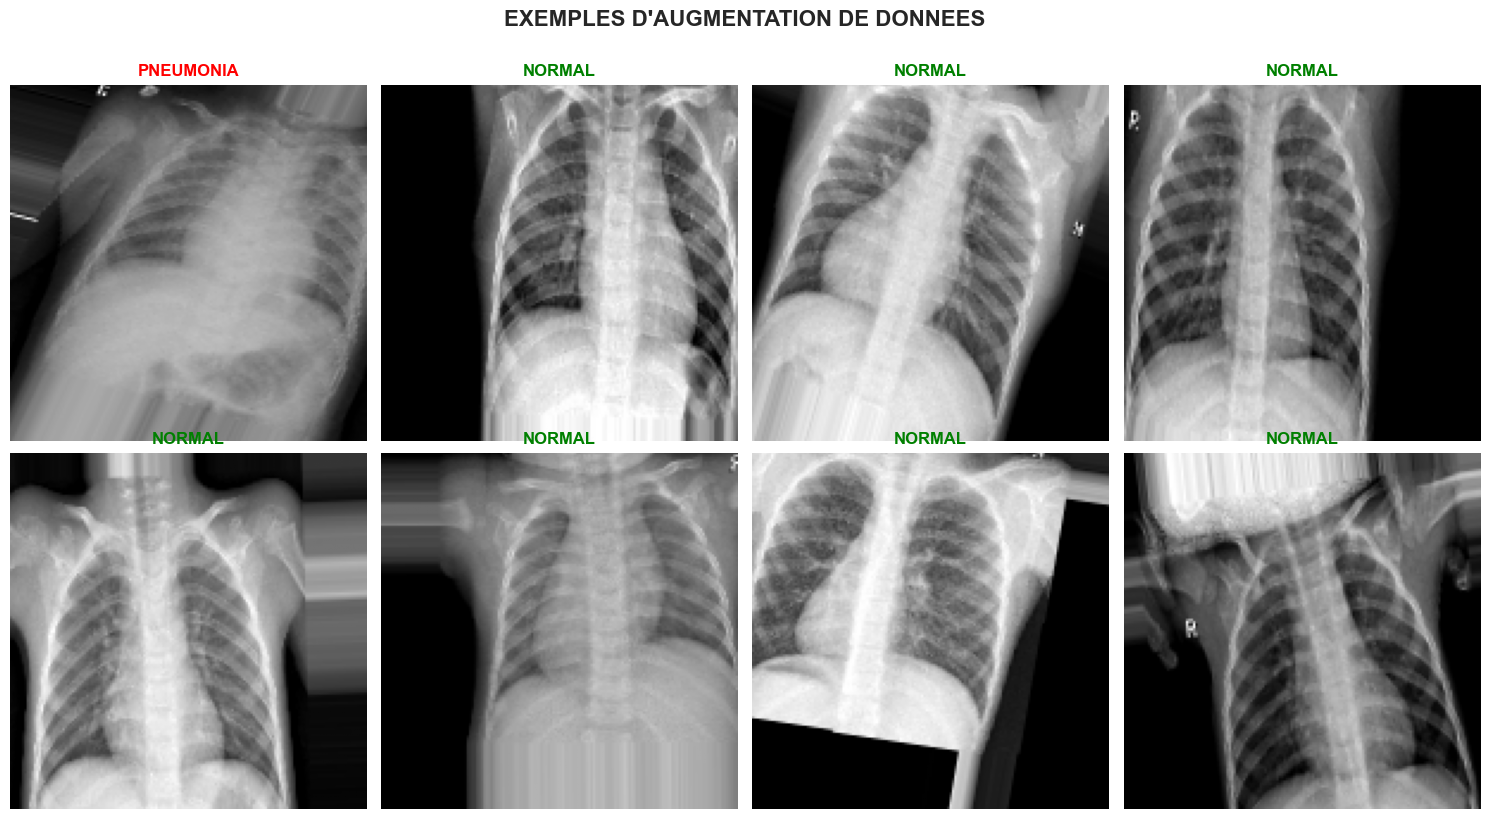

Augmentation des donnees configuree avec succes!


In [55]:
# Configuration des parametres
img_width, img_height = 150, 150
batch_size = 32

print("=" * 60)
print("CONFIGURATION DE L'AUGMENTATION DES DONNEES")
print("=" * 60)

# Generateur d'entrainement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generateur de test (normalisation uniquement)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creation des generateurs
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

# Calcul des steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

print(f"\nPARAMETRES D'ENTRAINEMENT:")
print(f"   - Steps per epoch       : {steps_per_epoch}")
print(f"   - Validation steps      : {validation_steps}")
print(f"   - Data augmentation     : ACTIVEE")
print(f"   - Class weights         : NON (data augmentation utilisee)")

# Visualisation de quelques images augmentees
print("\nVisualisation de l'augmentation des donnees...")

plt.figure(figsize=(15, 8))
plt.suptitle("EXEMPLES D'AUGMENTATION DE DONNEES", fontsize=16, fontweight='bold', y=1.02)

# Recuperer un batch d'images
sample_batch, sample_labels = next(train_generator)

# Afficher 8 exemples
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_batch[i].reshape(img_width, img_height), cmap='gray')
    
    # Determiner la classe (0=NORMAL, 1=PNEUMONIA)
    class_label = "PNEUMONIA" if np.argmax(sample_labels[i]) == 1 else "NORMAL"
    color = 'red' if class_label == "PNEUMONIA" else 'green'
    
    plt.title(f"{class_label}", fontweight='bold', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Augmentation des donnees configuree avec succes!")

# CONSTRUCTION DU MODÈLE CNN PERSONNALISÉ 


In [56]:
# Création du modèle séquentiel
model = Sequential(name="Pneumonia_Detection_CNN")

# Première couche de convolution (32 filtres, 3x3)
model.add(Conv2D(32, (3, 3), 
                 strides=1, 
                 padding='same', 
                 activation='relu', 
                 input_shape=(img_width, img_height, 1),
                 name='conv1'))
model.add(BatchNormalization(name='bn1'))          # Normalisation des activations
model.add(MaxPooling2D((2, 2), strides=2, padding='same', name='pool1'))

# Deuxième couche de convolution (64 filtres, 3x3)
model.add(Conv2D(64, (3, 3), 
                 strides=1, 
                 padding='same', 
                 activation='relu',
                 name='conv2'))
model.add(BatchNormalization(name='bn2'))          # Normalisation
model.add(MaxPooling2D((2, 2), strides=2, padding='same', name='pool2'))
model.add(Dropout(0.1, name='dropout1'))           # Dropout léger pour régularisation

# Troisième couche de convolution (64 filtres, 3x3)
model.add(Conv2D(64, (3, 3), 
                 strides=1, 
                 padding='same', 
                 activation='relu',
                 name='conv3'))
model.add(BatchNormalization(name='bn3'))          # Normalisation
model.add(MaxPooling2D((2, 2), strides=2, padding='same', name='pool3'))

# Quatrième couche de convolution (128 filtres, 3x3)
model.add(Conv2D(128, (3, 3), 
                 strides=1, 
                 padding='same', 
                 activation='relu',
                 name='conv4'))
model.add(BatchNormalization(name='bn4'))          # Normalisation
model.add(MaxPooling2D((2, 2), strides=2, padding='same', name='pool4'))
model.add(Dropout(0.2, name='dropout2'))           # Dropout modéré

# Cinquième couche de convolution (256 filtres, 3x3)
model.add(Conv2D(256, (3, 3), 
                 strides=1, 
                 padding='same', 
                 activation='relu',
                 name='conv5'))
model.add(BatchNormalization(name='bn5'))          # Normalisation
model.add(MaxPooling2D((2, 2), strides=2, padding='same', name='pool5'))
model.add(Dropout(0.2, name='dropout3'))           # Dropout modéré

# ========== COUCHES FULLY CONNECTED ==========
# Aplatissement des feature maps
model.add(Flatten(name='flatten'))

# Couche dense avec 128 neurones
model.add(Dense(128, activation='relu', name='fc1'))
model.add(BatchNormalization(name='bn_fc'))        # Normalisation de la couche dense
model.add(Dropout(0.3, name='dropout_fc'))         # Dropout plus fort avant la sortie

# ========== COUCHE DE SORTIE ==========
model.add(Dense(2, activation='softmax', name='output'))


In [57]:
model.summary()

Model: "Pneumonia_Detection_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 150, 150, 32)      320       
                                                                 
 bn1 (BatchNormalization)    (None, 150, 150, 32)      128       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 75, 75, 64)        18496     
                                                                 
 bn2 (BatchNormalization)    (None, 75, 75, 64)        256       
                                                                 
 pool2 (MaxPooling2D)        (None, 38, 38, 64)        0         
                                                                 
 dropout1 (Dropout)          (None, 38, 38,

# COMPILATION DU MODELE

In [58]:
model.compile(
    optimizer='adam',                              # Optimiseur Adam (adaptatif)
    loss='categorical_crossentropy',               # CRITIQUE : categorical pour softmax avec 2 sorties
    metrics=['accuracy',                           # Précision globale
              tf.keras.metrics.Precision(name='precision'),      # Précision (VP / VP+FP)
              tf.keras.metrics.Recall(name='recall'),            # Rappel/Sensibilité (VP / VP+FN)
              tf.keras.metrics.AUC(name='auc')]                 # Aire sous la courbe ROC
)


**Calcul du nombre total de paramètres**

In [59]:
total_params = model.count_params()
print(f"\nSTATISTIQUES DU MODÈLE:")
print(f"   - Paramètres totaux      : {total_params:,}")
print(f"   - Nombre de couches      : {len(model.layers)}")
print(f"   - Taille d'entrée        : ({img_width}, {img_height}, 1)")
print(f"   - Taille de sortie       : (2,) [NORMAL, PNEUMONIA]")



STATISTIQUES DU MODÈLE:
   - Paramètres totaux      : 1,247,042
   - Nombre de couches      : 23
   - Taille d'entrée        : (150, 150, 1)
   - Taille de sortie       : (2,) [NORMAL, PNEUMONIA]


# CONFIGURATION DES CALLBACKS

In [60]:
# Création du dossier pour sauvegarder les modèles
model_save_dir = 'models'
os.makedirs(model_save_dir, exist_ok=True)

# ========== CALLBACK 1 : ModelCheckpoint ==========
# Sauvegarde le meilleur modèle basé sur la validation loss
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_save_dir, 'best_model_custom_cnn.h5'),
    monitor='val_loss',              # Surveille la perte de validation
    save_best_only=True,             # Sauvegarde seulement si amélioration
    mode='min',                      # Minimiser la val_loss
    verbose=1                        # Affiche un message lors de la sauvegarde
)

# ========== CALLBACK 2 : EarlyStopping ==========
# Arrête l'entraînement si pas d'amélioration pendant N époques
early_stopping = EarlyStopping(
    monitor='val_loss',              # Surveille la perte de validation
    patience=5,                      # Attend 5 époques sans amélioration
    restore_best_weights=True,       # Restaure les meilleurs poids à la fin
    verbose=1,                       # Affiche un message lors de l'arrêt
    mode='min'                       # Minimiser la val_loss
)

# ========== CALLBACK 3 : ReduceLROnPlateau ==========
# Réduit le learning rate si le modèle stagne
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',              # Surveille la perte de validation
    factor=0.5,                      # Réduit le LR de moitié (LR *= 0.5)
    patience=3,                      # Attend 3 époques sans amélioration
    min_lr=1e-7,                     # Learning rate minimum
    verbose=1,                       # Affiche un message lors de la réduction
    mode='min'                       # Minimiser la val_loss
)

# Liste de tous les callbacks
callbacks_list = [checkpoint, early_stopping, reduce_lr]

print("\n Callbacks configurés:")
print("   1-ModelCheckpoint    → Sauvegarde le meilleur modèle")
print("   2️-EarlyStopping      → Arrête si pas d'amélioration (patience=5)")
print("   3️-ReduceLROnPlateau  → Réduit le LR si stagnation (patience=3)")








 Callbacks configurés:
   1-ModelCheckpoint    → Sauvegarde le meilleur modèle
   2️-EarlyStopping      → Arrête si pas d'amélioration (patience=5)
   3️-ReduceLROnPlateau  → Réduit le LR si stagnation (patience=3)


# ENTRAÎNEMENT DU MODÈLE 

In [61]:
print("=" * 60)
print("ENTRAINEMENT DU MODELE CUSTOM CNN")
print("=" * 60)

# Callbacks
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join(model_save_dir, 'best_model_custom_cnn.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nDemarrage de l'entrainement...")
print("Data augmentation : ACTIVEE")
print("Class weights : NON UTILISES (data augmentation appliquee)\n")

# Entrainement
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)

print("\nEntrainement du Custom CNN termine!")

# Sauvegarde de l'historique
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(model_save_dir, 'history_custom_cnn.csv'), index=False)
print(f"Historique sauvegarde dans '{model_save_dir}/history_custom_cnn.csv'")

ENTRAINEMENT DU MODELE CUSTOM CNN

Demarrage de l'entrainement...
Data augmentation : ACTIVEE
Class weights : NON UTILISES (data augmentation appliquee)

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8399 - precision: 0.8399 - recall: 0.8399 - auc: 0.9074
Epoch 1: val_loss improved from inf to 2.92683, saving model to models\best_model_custom_cnn.h5
163/163 [==============================] - 29s 171ms/step - loss: 0.4071 - accuracy: 0.8399 - precision: 0.8399 - recall: 0.8399 - auc: 0.9074 - val_loss: 2.9268 - val_accuracy: 0.6151 - val_precision: 0.6151 - val_recall: 0.6151 - val_auc: 0.6151 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9667
Epoch 2: val_loss did not improve from 2.92683
163/163 [==============================] - 27s 163ms/step - loss: 0.2344 - accuracy: 0.9026 - precision: 0.9026 - recall: 0.9026 - auc: 0.9667 - val

# VISUALISATION DE L'ENTRAÎNEMENT

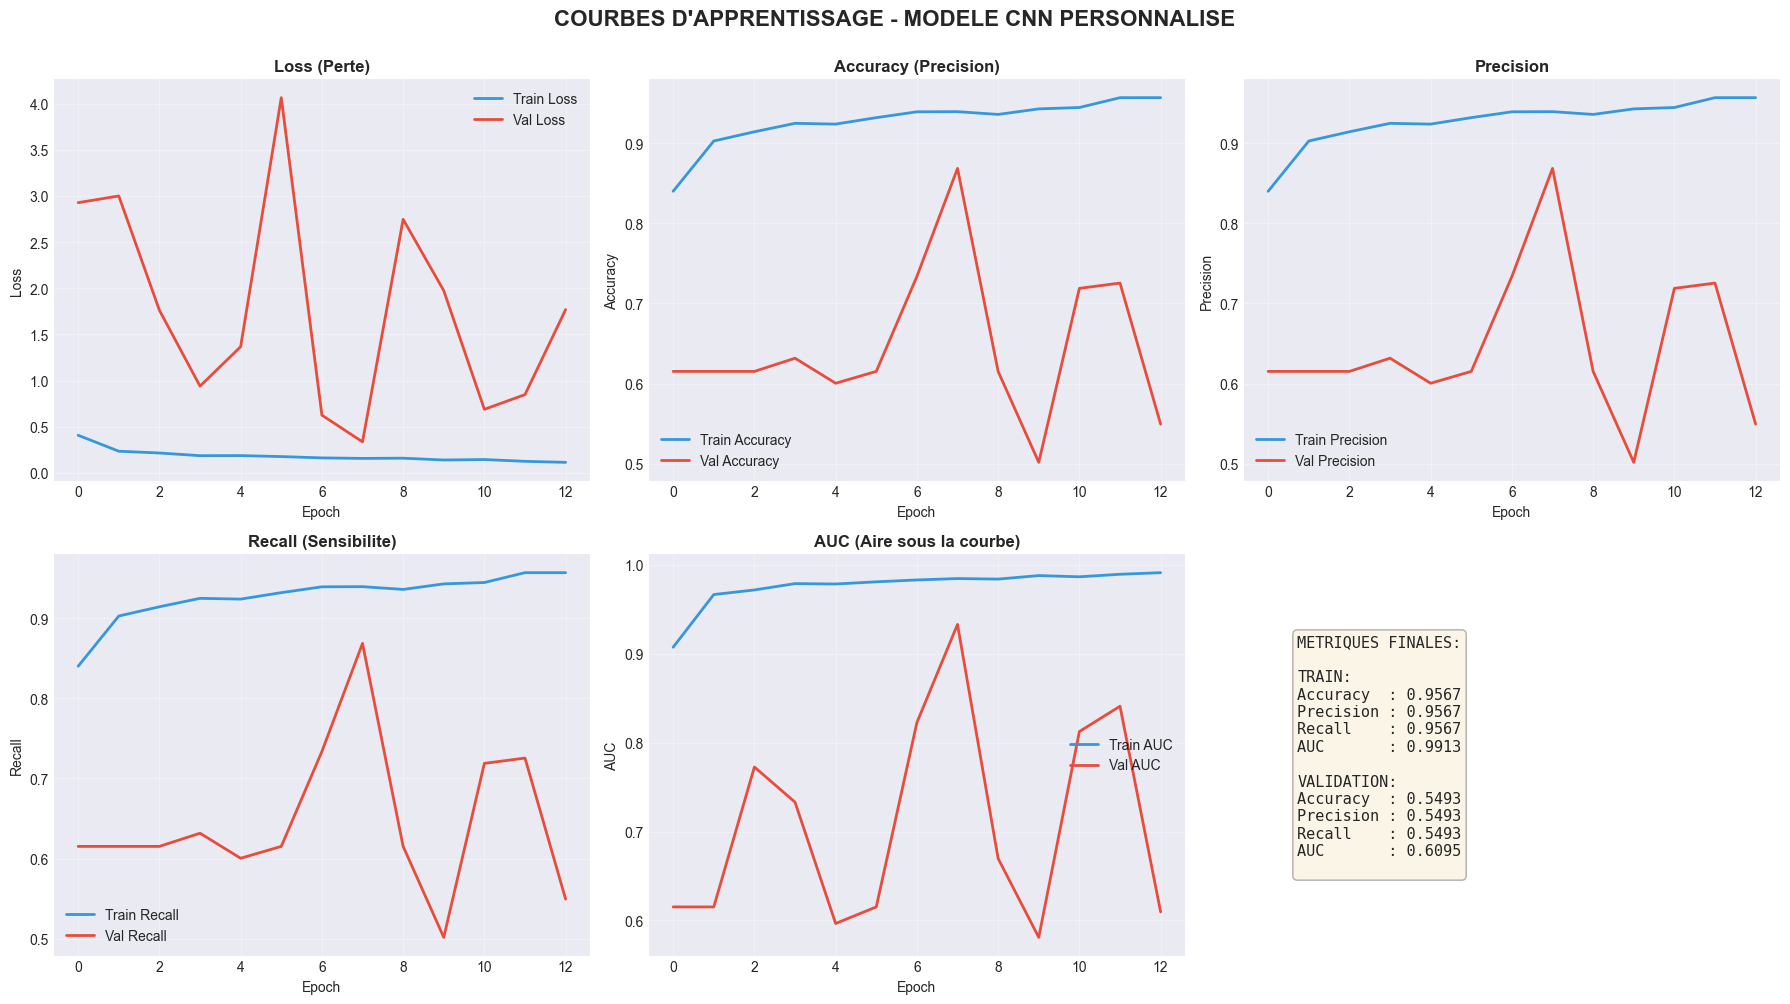

Courbes sauvegardees dans 'models/training_curves_custom_cnn.png'


In [62]:
# Visualisation des courbes d'apprentissage
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('COURBES D\'APPRENTISSAGE - MODELE CNN PERSONNALISE', 
             fontsize=16, fontweight='bold', y=1.00)

# Courbe 1 : Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='#3498db')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#e74c3c')
axes[0, 0].set_title('Loss (Perte)', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Courbe 2 : Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#3498db')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#e74c3c')
axes[0, 1].set_title('Accuracy (Precision)', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Courbe 3 : Precision
axes[0, 2].plot(history.history['precision'], label='Train Precision', linewidth=2, color='#3498db')
axes[0, 2].plot(history.history['val_precision'], label='Val Precision', linewidth=2, color='#e74c3c')
axes[0, 2].set_title('Precision', fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Courbe 4 : Recall
axes[1, 0].plot(history.history['recall'], label='Train Recall', linewidth=2, color='#3498db')
axes[1, 0].plot(history.history['val_recall'], label='Val Recall', linewidth=2, color='#e74c3c')
axes[1, 0].set_title('Recall (Sensibilite)', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Courbe 5 : AUC
axes[1, 1].plot(history.history['auc'], label='Train AUC', linewidth=2, color='#3498db')
axes[1, 1].plot(history.history['val_auc'], label='Val AUC', linewidth=2, color='#e74c3c')
axes[1, 1].set_title('AUC (Aire sous la courbe)', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Metriques finales
axes[1, 2].axis('off')
final_metrics = f"""METRIQUES FINALES:

TRAIN:
Accuracy  : {history.history['accuracy'][-1]:.4f}
Precision : {history.history['precision'][-1]:.4f}
Recall    : {history.history['recall'][-1]:.4f}
AUC       : {history.history['auc'][-1]:.4f}

VALIDATION:
Accuracy  : {history.history['val_accuracy'][-1]:.4f}
Precision : {history.history['val_precision'][-1]:.4f}
Recall    : {history.history['val_recall'][-1]:.4f}
AUC       : {history.history['val_auc'][-1]:.4f}
"""
axes[1, 2].text(0.1, 0.5, final_metrics, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'training_curves_custom_cnn.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Courbes sauvegardees dans 'models/training_curves_custom_cnn.png'")

# ÉVALUATION COMPLÈTE DU MODÈLE

EVALUATION COMPLETE DU MODELE CUSTOM CNN

Generation des predictions...
19/19 [==============================] - 2s 94ms/step

METRIQUES GLOBALES
Accuracy  : 0.8684
Precision : 0.8889
Recall    : 0.8984
F1-Score  : 0.8936

MATRICE DE CONFUSION
[[192  42]
 [ 38 336]]


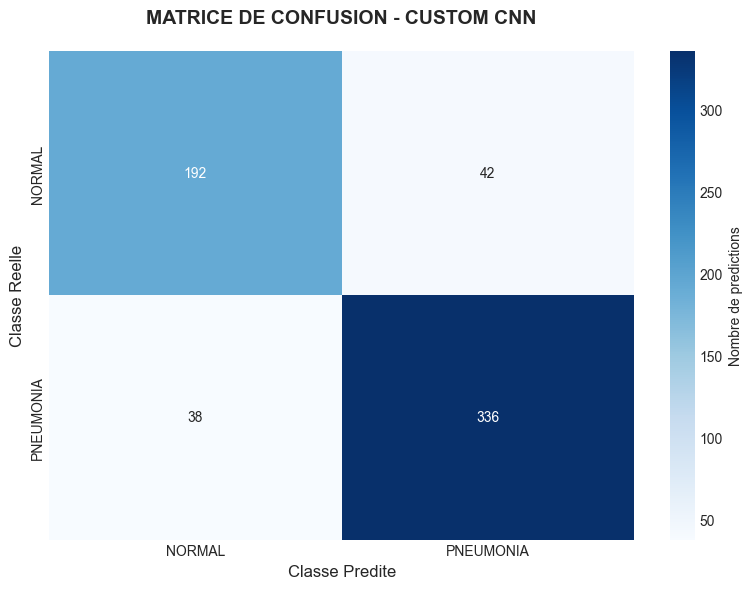


COURBE ROC
AUC-ROC : 0.9255


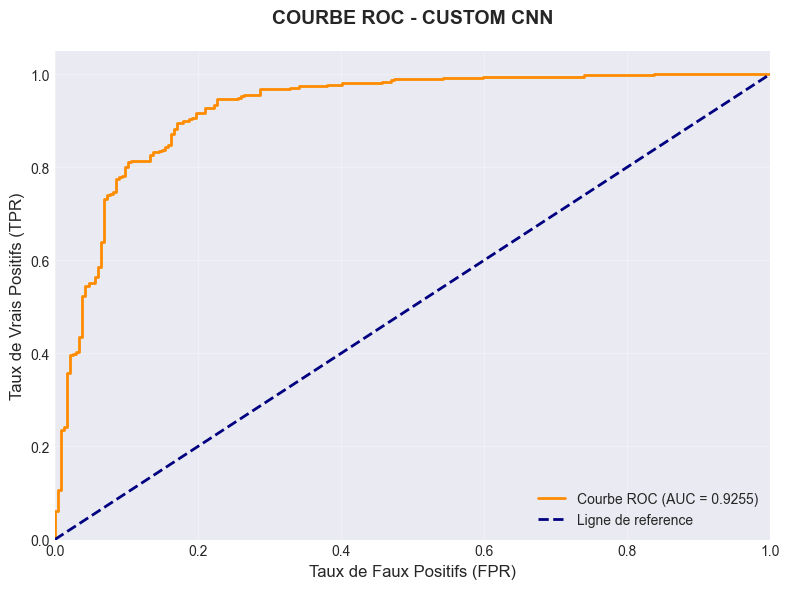


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

      NORMAL       0.83      0.82      0.83       234
   PNEUMONIA       0.89      0.90      0.89       374

    accuracy                           0.87       608
   macro avg       0.86      0.86      0.86       608
weighted avg       0.87      0.87      0.87       608


Evaluation sauvegardee dans 'models/'


In [63]:
print("=" * 60)
print("EVALUATION COMPLETE DU MODELE CUSTOM CNN")
print("=" * 60)

# Predictions sur l'ensemble de test
print("\nGeneration des predictions...")
validation_generator.reset()
y_pred_proba = model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = validation_generator.classes[:len(y_pred)]

class_names = ['NORMAL', 'PNEUMONIA']

# Metriques globales
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n" + "=" * 60)
print("METRIQUES GLOBALES")
print("=" * 60)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Sauvegarde des metriques dans un fichier
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})
metrics_df.to_csv(os.path.join(model_save_dir, 'metrics_custom_cnn.csv'), index=False)

# VISUALISATION 1 : CONFUSION MATRIX
print("\n" + "=" * 60)
print("MATRICE DE CONFUSION")
print("=" * 60)

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de predictions'})
plt.title('MATRICE DE CONFUSION - CUSTOM CNN', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Classe Reelle', fontsize=12)
plt.xlabel('Classe Predite', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'confusion_matrix_custom_cnn.png'), dpi=300, bbox_inches='tight')
plt.show()

# VISUALISATION 2 : COURBE ROC
print("\n" + "=" * 60)
print("COURBE ROC")
print("=" * 60)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC-ROC : {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de reference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('COURBE ROC - CUSTOM CNN', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'roc_curve_custom_cnn.png'), dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification detaille
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names))

# Sauvegarde du rapport
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_save_dir, 'classification_report_custom_cnn.csv'))

print(f"\nEvaluation sauvegardee dans '{model_save_dir}/'")

# PRÉDICTION SUR UNE IMAGE INDIVIDUELLE

TEST DE PREDICTION SUR UNE IMAGE - CUSTOM CNN

Test 1: Image PNEUMONIA


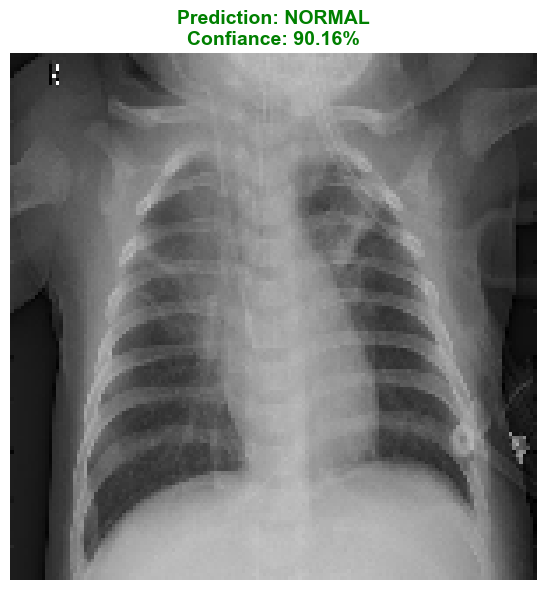

Classe predite : NORMAL
Confiance      : 90.16%

Test 2: Image NORMAL


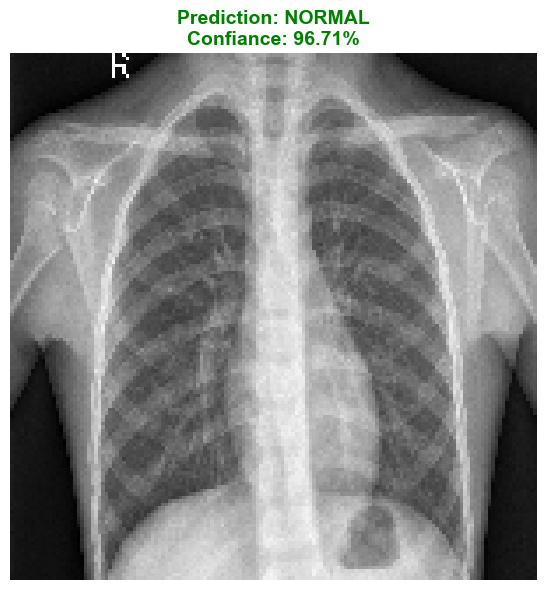

Classe predite : NORMAL
Confiance      : 96.71%

Tests de prediction termines!


In [64]:
print("=" * 60)
print("TEST DE PREDICTION SUR UNE IMAGE - CUSTOM CNN")
print("=" * 60)

def predict_single_image(img_path, model, img_size=(150, 150), is_rgb=False):
    """Prediction sur une seule image"""
    color_mode = 'rgb' if is_rgb else 'grayscale'
    img = keras_image.load_img(img_path, target_size=img_size, color_mode=color_mode)
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    class_label = 'NORMAL' if predicted_class == 0 else 'PNEUMONIA'
    
    # Affichage
    plt.figure(figsize=(6, 6))
    if is_rgb:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    
    color = 'green' if predicted_class == 0 else 'red'
    plt.title(f'Prediction: {class_label}\nConfiance: {confidence:.2%}', 
              fontsize=14, fontweight='bold', color=color)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Classe predite : {class_label}")
    print(f"Confiance      : {confidence:.2%}")
    
    return class_label, confidence

# Test 1: Image PNEUMONIA
print("\nTest 1: Image PNEUMONIA")
test_image_pneumonia = 'chest_xray/test/PNEUMONIA/person8_virus_27.jpeg'
predict_single_image(test_image_pneumonia, model, img_size=(150, 150), is_rgb=False)

# Test 2: Image NORMAL
print("\nTest 2: Image NORMAL")
test_image_normal = 'chest_xray/test/NORMAL/IM-0001-0001.jpeg'
predict_single_image(test_image_normal, model, img_size=(150, 150), is_rgb=False)

print("\nTests de prediction termines!")

# GÉNÉRATEURS POUR TRANSFER LEARNING (RGB 224x224)

In [65]:
print("=" * 60)
print("CONFIGURATION TRANSFER LEARNING")
print("=" * 60)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parametres globaux pour Transfer Learning
img_size = (224, 224)
batch_size = 32

def create_tl_generators(train_dir, test_dir, img_size=img_size, batch_size=batch_size, augment=True):
    """Cree les generateurs pour tous les modeles TL (DenseNet121, VGG16, EfficientNetB0)"""
    
    # Generateur d'entrainement avec augmentation
    if augment:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
    
    # Generateur de validation (pas d'augmentation)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )
    
    return train_gen, val_gen

# Generation unique des generateurs
train_generator, validation_generator = create_tl_generators(train_dir, test_dir)

print("\nGenerateurs crees avec succes!")
print(f"   - Taille des images : {img_size}")
print(f"   - Batch size        : {batch_size}")
print(f"   - Data augmentation : ACTIVEE")
print(f"   - Class weights     : NON UTILISES")

CONFIGURATION TRANSFER LEARNING
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Generateurs crees avec succes!
   - Taille des images : (224, 224)
   - Batch size        : 32
   - Data augmentation : ACTIVEE
   - Class weights     : NON UTILISES


#  Transfer learning MODÈLE DENSENET121 


In [66]:
print("=" * 60)
print("TRANSFER LEARNING - DENSENET121")
print("=" * 60)

from tensorflow.keras.applications import DenseNet121

# Construction du modele DenseNet121
base_model_dense = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Geler les couches du modele pre-entraine
base_model_dense.trainable = False

# Construction du modele complet
model_densenet = Sequential([
    base_model_dense,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
], name='DenseNet121_Pneumonia')

print("\nArchitecture DenseNet121:")
model_densenet.summary()

# Compilation
model_densenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Callbacks
callbacks_dense = [
    ModelCheckpoint(
        filepath=os.path.join(model_save_dir, 'best_model_densenet121.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nDemarrage de l'entrainement DenseNet121...")
print("Data augmentation : ACTIVEE")
print("Class weights : NON UTILISES\n")

# Entrainement
history_dense = model_densenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks_dense,
    verbose=1
)

print("\nEntrainement DenseNet121 termine!")

# Sauvegarde historique
history_dense_df = pd.DataFrame(history_dense.history)
history_dense_df.to_csv(os.path.join(model_save_dir, 'history_densenet121.csv'), index=False)

TRANSFER LEARNING - DENSENET121

Architecture DenseNet121:
Model: "DenseNet121_Pneumonia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_21  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_63 (Dense)            (None, 256)               262400    
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_64 (Dense)            (None, 128)               32896     
                                                                 
 dropout_43 (Dropout)        (None, 128)            

# DENSENET121 - COURBES FINE-TUNING

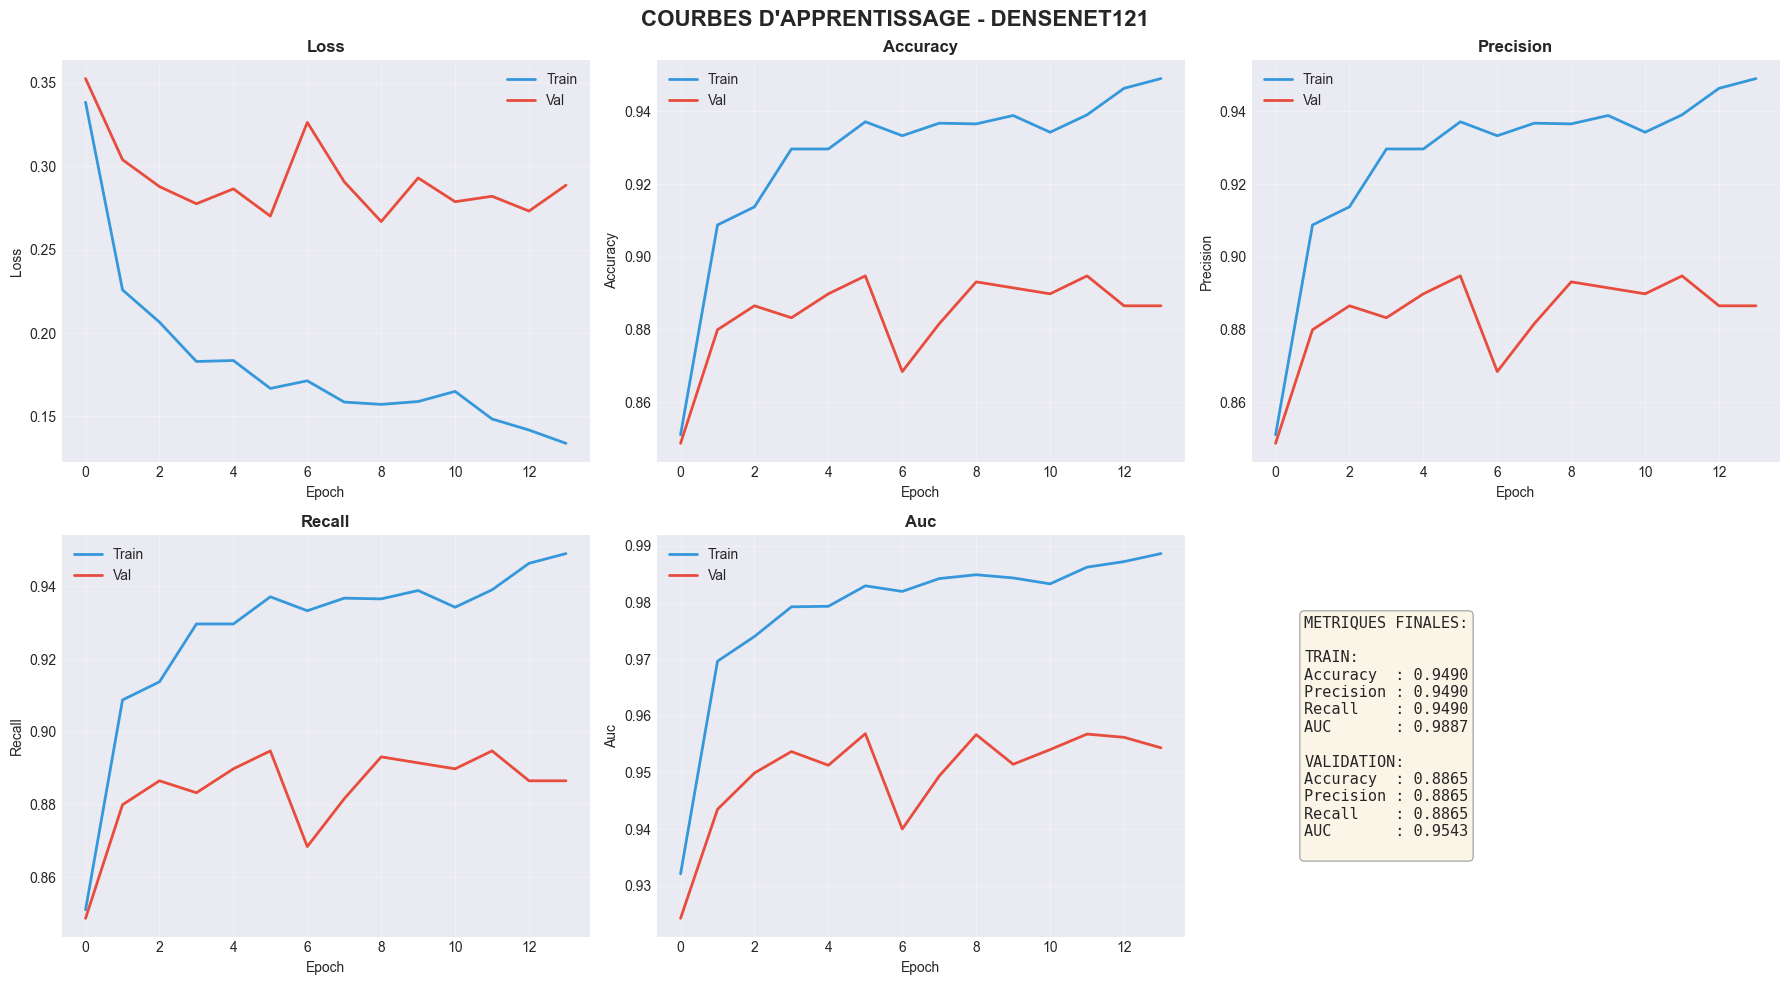

Courbes sauvegardees dans 'models/training_curves_densenet121.png'


In [67]:
# Visualisation des courbes DenseNet121
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('COURBES D\'APPRENTISSAGE - DENSENET121', fontsize=16, fontweight='bold')

metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
colors = ['#3498db', '#e74c3c']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].plot(history_dense.history[metric], label='Train', linewidth=2, color=colors[0])
    axes[row, col].plot(history_dense.history[f'val_{metric}'], label='Val', linewidth=2, color=colors[1])
    axes[row, col].set_title(metric.capitalize(), fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel(metric.capitalize())
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)

# Metriques finales
axes[1, 2].axis('off')
final_dense = f"""METRIQUES FINALES:

TRAIN:
Accuracy  : {history_dense.history['accuracy'][-1]:.4f}
Precision : {history_dense.history['precision'][-1]:.4f}
Recall    : {history_dense.history['recall'][-1]:.4f}
AUC       : {history_dense.history['auc'][-1]:.4f}

VALIDATION:
Accuracy  : {history_dense.history['val_accuracy'][-1]:.4f}
Precision : {history_dense.history['val_precision'][-1]:.4f}
Recall    : {history_dense.history['val_recall'][-1]:.4f}
AUC       : {history_dense.history['val_auc'][-1]:.4f}
"""
axes[1, 2].text(0.1, 0.5, final_dense, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'training_curves_densenet121.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Courbes sauvegardees dans '{model_save_dir}/training_curves_densenet121.png'")

# DENSENET121 -EVALUATION COMPLETE

EVALUATION COMPLETE - DENSENET121

Generation des predictions...
19/19 [==============================] - 5s 181ms/step

METRIQUES GLOBALES
Accuracy  : 0.8931
Precision : 0.8992
Recall    : 0.9305
F1-Score  : 0.9146

MATRICE DE CONFUSION
[[195  39]
 [ 26 348]]


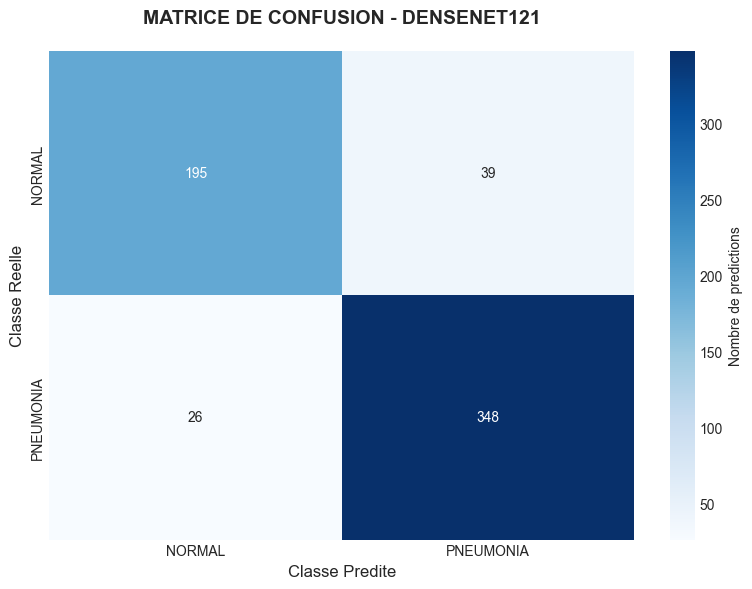


COURBE ROC
AUC-ROC : 0.9592


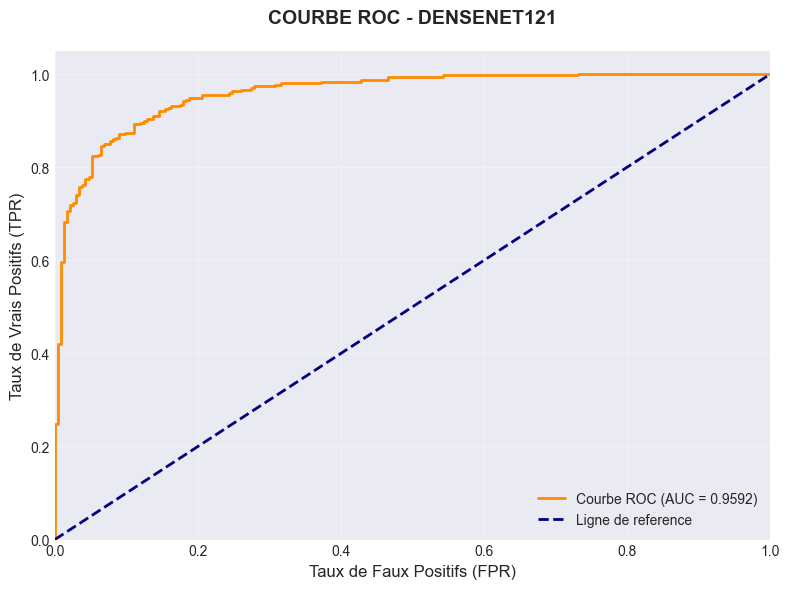


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

      NORMAL       0.88      0.83      0.86       234
   PNEUMONIA       0.90      0.93      0.91       374

    accuracy                           0.89       608
   macro avg       0.89      0.88      0.89       608
weighted avg       0.89      0.89      0.89       608


Evaluation sauvegardee dans 'models/'


In [68]:
print("=" * 60)
print("EVALUATION COMPLETE - DENSENET121")
print("=" * 60)

# Predictions
print("\nGeneration des predictions...")
validation_generator.reset()
y_pred_proba_dense = model_densenet.predict(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
y_pred_dense = np.argmax(y_pred_proba_dense, axis=1)
y_true_dense = validation_generator.classes[:len(y_pred_dense)]

class_names = ['NORMAL', 'PNEUMONIA']

# Metriques globales
accuracy_dense = np.mean(y_pred_dense == y_true_dense)
precision_dense = precision_score(y_true_dense, y_pred_dense)
recall_dense = recall_score(y_true_dense, y_pred_dense)
f1_dense = f1_score(y_true_dense, y_pred_dense)

print("\n" + "=" * 60)
print("METRIQUES GLOBALES")
print("=" * 60)
print(f"Accuracy  : {accuracy_dense:.4f}")
print(f"Precision : {precision_dense:.4f}")
print(f"Recall    : {recall_dense:.4f}")
print(f"F1-Score  : {f1_dense:.4f}")

# Sauvegarde des metriques
metrics_dense_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy_dense, precision_dense, recall_dense, f1_dense]
})
metrics_dense_df.to_csv(os.path.join(model_save_dir, 'metrics_densenet121.csv'), index=False)

# VISUALISATION 1 : CONFUSION MATRIX
print("\n" + "=" * 60)
print("MATRICE DE CONFUSION")
print("=" * 60)

cm_dense = confusion_matrix(y_true_dense, y_pred_dense)
print(cm_dense)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de predictions'})
plt.title('MATRICE DE CONFUSION - DENSENET121', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Classe Reelle', fontsize=12)
plt.xlabel('Classe Predite', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'confusion_matrix_densenet121.png'), dpi=300, bbox_inches='tight')
plt.show()

# VISUALISATION 2 : COURBE ROC
print("\n" + "=" * 60)
print("COURBE ROC")
print("=" * 60)

fpr_dense, tpr_dense, _ = roc_curve(y_true_dense, y_pred_proba_dense[:, 1])
roc_auc_dense = auc(fpr_dense, tpr_dense)

print(f"AUC-ROC : {roc_auc_dense:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_dense, tpr_dense, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc_dense:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de reference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('COURBE ROC - DENSENET121', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'roc_curve_densenet121.png'), dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(y_true_dense, y_pred_dense, target_names=class_names))

# Sauvegarde du rapport
report_dict_dense = classification_report(y_true_dense, y_pred_dense, target_names=class_names, output_dict=True)
report_df_dense = pd.DataFrame(report_dict_dense).transpose()
report_df_dense.to_csv(os.path.join(model_save_dir, 'classification_report_densenet121.csv'))

print(f"\nEvaluation sauvegardee dans '{model_save_dir}/'")

# Fine-tuning DenseNet121

Pour améliorer les performances de notre modèle DenseNet121 sur notre dataset spécifique de 5000 images, nous allons appliquer un fine-tuning progressif. Concrètement, nous allons d'abord entraîner uniquement les couches supérieures personnalisées ajoutées au modèle pré-entraîné (feature extractor), puis nous débloquerons progressivement les dernières couches convolutives du DenseNet pour un entraînement léger. Cela permet au modèle de s’adapter aux caractéristiques spécifiques de notre jeu de données tout en conservant les connaissances générales apprises sur ImageNet.

In [69]:
print("=" * 60)
print("FINE-TUNING - DENSENET121")
print("=" * 60)

print("\nDegel des dernieres couches de DenseNet121...")

# Debloquer les dernieres couches pour fine-tuning
base_model_dense.trainable = True

# Compter le nombre total de couches
total_layers = len(base_model_dense.layers)
print(f"Nombre total de couches : {total_layers}")

# Geler toutes les couches sauf les 50 dernieres
freeze_until = total_layers - 50
for i, layer in enumerate(base_model_dense.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

# Compter les couches trainables
trainable_count = sum([1 for layer in base_model_dense.layers if layer.trainable])
print(f"Couches degelees : {trainable_count}/{total_layers}")

# Recompilation avec learning rate plus faible
from tensorflow.keras.optimizers import Adam

model_densenet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("\nDemarrage du fine-tuning...")
print("Learning rate : 1e-5")
print("Epochs : 10")
print("Data augmentation : ACTIVEE")
print("Class weights : NON UTILISES\n")

import time
start_time = time.time()

# Fine-tuning
history_finetune = model_densenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks_dense,
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

print("\nFine-tuning DenseNet121 termine!")

# Sauvegarde historique
history_finetune_df = pd.DataFrame(history_finetune.history)
history_finetune_df.to_csv(os.path.join(model_save_dir, 'history_densenet121_finetune.csv'), index=False)

# Resume du fine-tuning
print("\n" + "=" * 60)
print("RESUME DU FINE-TUNING - DENSENET121")
print("=" * 60)

initial_val_acc = history_dense.history['val_accuracy'][-1]
finetuned_val_acc = history_finetune.history['val_accuracy'][-1]
improvement = (finetuned_val_acc - initial_val_acc) * 100

print(f"""
CONFIGURATION:
- Couches degelees        : {trainable_count} sur {total_layers}
- Learning rate           : 1e-5
- Epochs de fine-tuning   : {len(history_finetune.history['loss'])}
- Temps d'entrainement    : {training_time/60:.2f} minutes

METRIQUES AVANT FINE-TUNING:
- Validation Accuracy     : {initial_val_acc:.4f}
- Validation Precision    : {history_dense.history['val_precision'][-1]:.4f}
- Validation Recall       : {history_dense.history['val_recall'][-1]:.4f}
- Validation AUC          : {history_dense.history['val_auc'][-1]:.4f}

METRIQUES APRES FINE-TUNING:
- Validation Accuracy     : {finetuned_val_acc:.4f}
- Validation Precision    : {history_finetune.history['val_precision'][-1]:.4f}
- Validation Recall       : {history_finetune.history['val_recall'][-1]:.4f}
- Validation AUC          : {history_finetune.history['val_auc'][-1]:.4f}

AMELIORATION:
- Gain d'accuracy         : {improvement:+.2f}%
""")

print("=" * 60)

FINE-TUNING - DENSENET121

Degel des dernieres couches de DenseNet121...
Nombre total de couches : 427
Couches degelees : 50/427

Demarrage du fine-tuning...
Learning rate : 1e-5
Epochs : 10
Data augmentation : ACTIVEE
Class weights : NON UTILISES

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9793
Epoch 1: val_loss did not improve from 0.26689
163/163 [==============================] - 78s 446ms/step - loss: 0.1915 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9793 - val_loss: 0.2927 - val_accuracy: 0.9030 - val_precision: 0.9030 - val_recall: 0.9030 - val_auc: 0.9543 - lr: 1.0000e-05
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9838
Epoch 2: val_loss did not improve from 0.26689
163/163 [==============================] - 73s 447ms/step - loss: 0.1646 - accuracy: 0.9400 - prec

# DENSENET121 -  COURBES FINE-TUNING

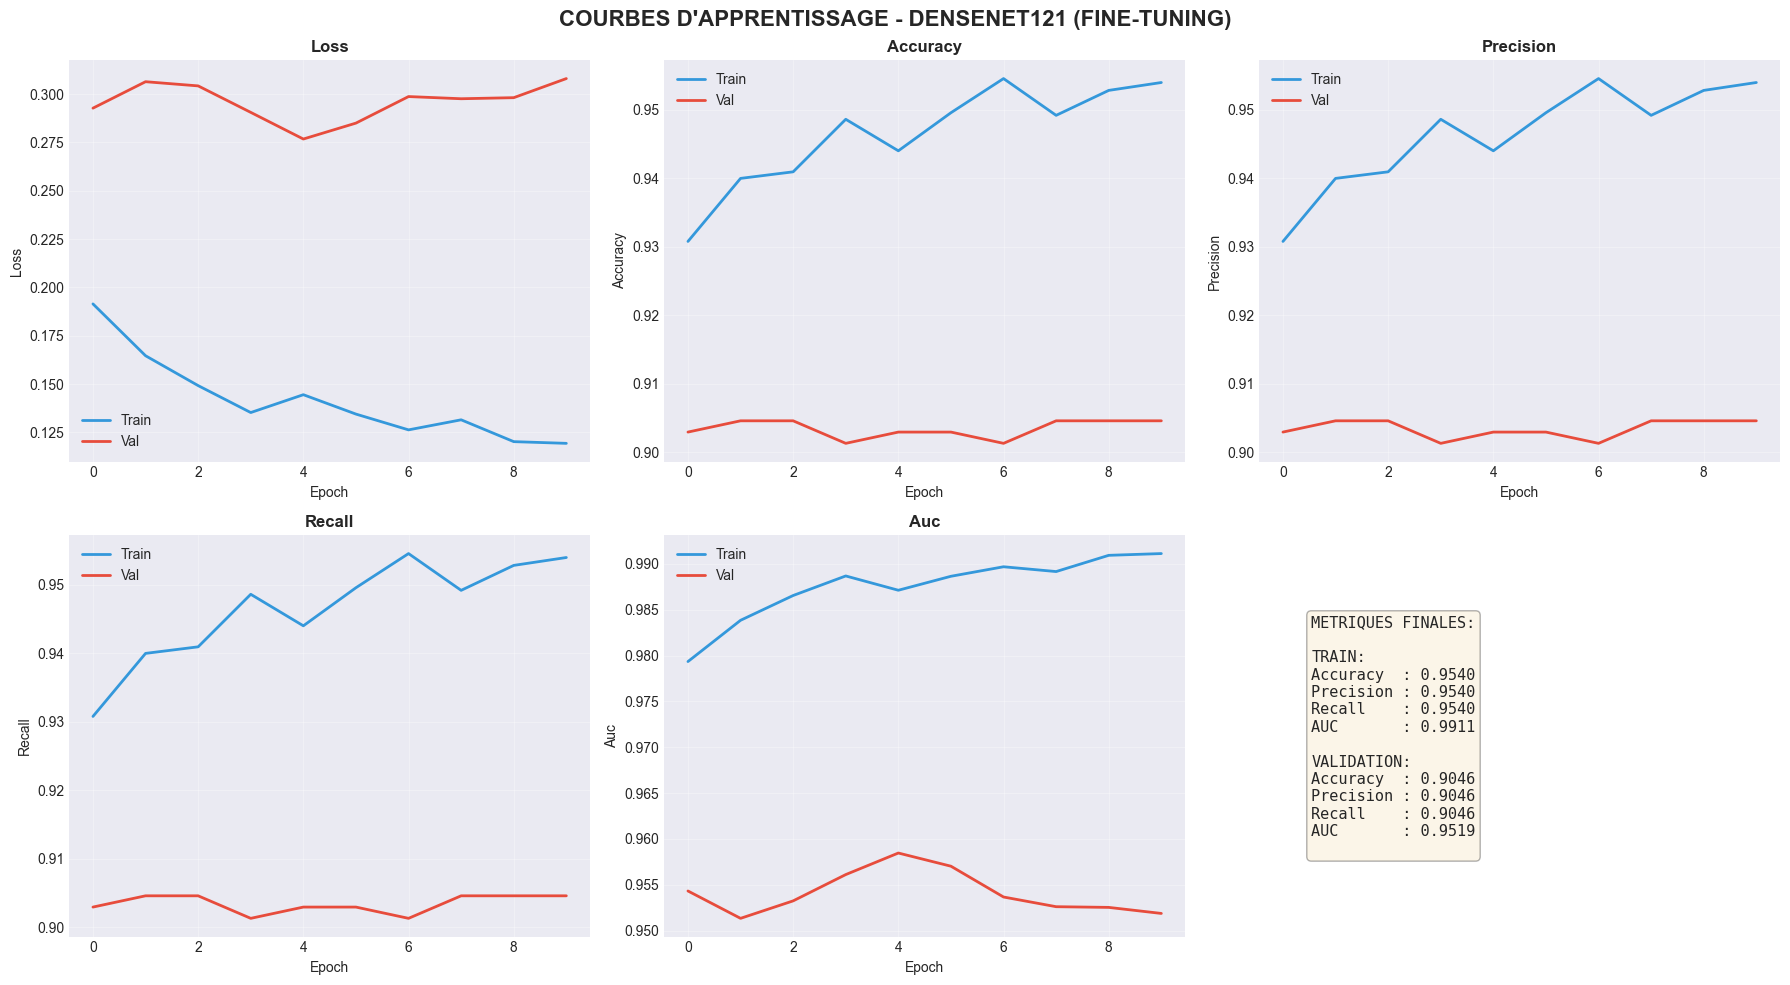

Courbes de fine-tuning sauvegardees dans 'models/finetuning_curves_densenet121.png'


In [70]:
# Visualisation des courbes de fine-tuning
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('COURBES D\'APPRENTISSAGE - DENSENET121 (FINE-TUNING)', fontsize=16, fontweight='bold')

metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
colors = ['#3498db', '#e74c3c']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].plot(history_finetune.history[metric], label='Train', linewidth=2, color=colors[0])
    axes[row, col].plot(history_finetune.history[f'val_{metric}'], label='Val', linewidth=2, color=colors[1])
    axes[row, col].set_title(metric.capitalize(), fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel(metric.capitalize())
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)

# Metriques finales
axes[1, 2].axis('off')
final_finetune = f"""METRIQUES FINALES:

TRAIN:
Accuracy  : {history_finetune.history['accuracy'][-1]:.4f}
Precision : {history_finetune.history['precision'][-1]:.4f}
Recall    : {history_finetune.history['recall'][-1]:.4f}
AUC       : {history_finetune.history['auc'][-1]:.4f}

VALIDATION:
Accuracy  : {history_finetune.history['val_accuracy'][-1]:.4f}
Precision : {history_finetune.history['val_precision'][-1]:.4f}
Recall    : {history_finetune.history['val_recall'][-1]:.4f}
AUC       : {history_finetune.history['val_auc'][-1]:.4f}
"""
axes[1, 2].text(0.1, 0.5, final_finetune, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'finetuning_curves_densenet121.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Courbes de fine-tuning sauvegardees dans '{model_save_dir}/finetuning_curves_densenet121.png'")

# DENSENET121 FT - EVALUATION COMPLETE



EVALUATION COMPLETE - DENSENET121 FINE-TUNED

Generation des predictions...
19/19 [==============================] - 6s 200ms/step

METRIQUES GLOBALES
Accuracy  : 0.9030
Precision : 0.9070
Recall    : 0.9385
F1-Score  : 0.9225

MATRICE DE CONFUSION
[[198  36]
 [ 23 351]]


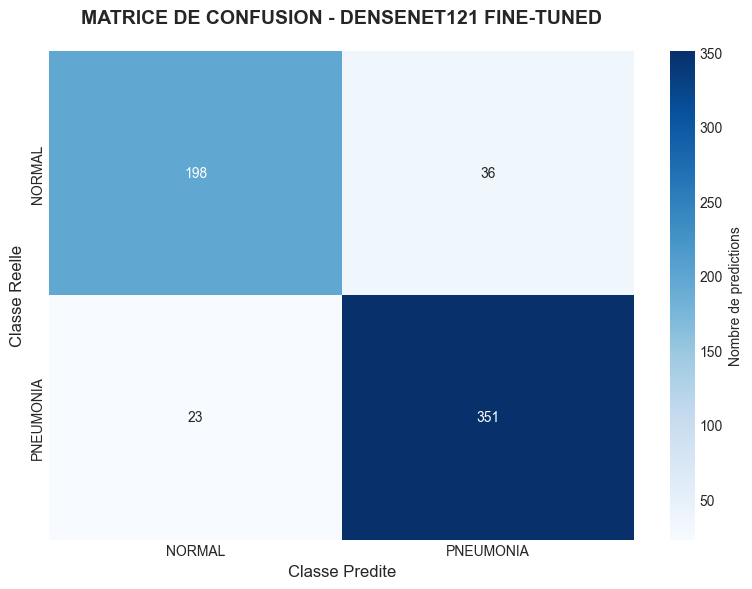


COURBE ROC
AUC-ROC : 0.9646


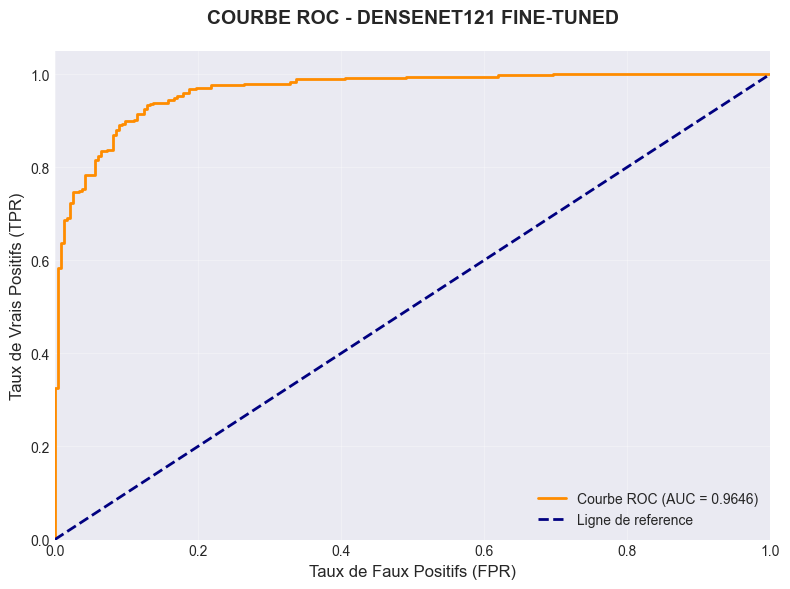


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

      NORMAL       0.90      0.85      0.87       234
   PNEUMONIA       0.91      0.94      0.92       374

    accuracy                           0.90       608
   macro avg       0.90      0.89      0.90       608
weighted avg       0.90      0.90      0.90       608


Evaluation sauvegardee dans 'models/'


In [71]:
print("=" * 60)
print("EVALUATION COMPLETE - DENSENET121 FINE-TUNED")
print("=" * 60)

# Predictions avec le modele fine-tune
print("\nGeneration des predictions...")
validation_generator.reset()
y_pred_proba_dense_ft = model_densenet.predict(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
y_pred_dense_ft = np.argmax(y_pred_proba_dense_ft, axis=1)
y_true_dense_ft = validation_generator.classes[:len(y_pred_dense_ft)]

class_names = ['NORMAL', 'PNEUMONIA']

# Metriques globales
accuracy_dense_ft = np.mean(y_pred_dense_ft == y_true_dense_ft)
precision_dense_ft = precision_score(y_true_dense_ft, y_pred_dense_ft)
recall_dense_ft = recall_score(y_true_dense_ft, y_pred_dense_ft)
f1_dense_ft = f1_score(y_true_dense_ft, y_pred_dense_ft)

print("\n" + "=" * 60)
print("METRIQUES GLOBALES")
print("=" * 60)
print(f"Accuracy  : {accuracy_dense_ft:.4f}")
print(f"Precision : {precision_dense_ft:.4f}")
print(f"Recall    : {recall_dense_ft:.4f}")
print(f"F1-Score  : {f1_dense_ft:.4f}")

# Sauvegarde des metriques
metrics_dense_ft_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy_dense_ft, precision_dense_ft, recall_dense_ft, f1_dense_ft]
})
metrics_dense_ft_df.to_csv(os.path.join(model_save_dir, 'metrics_densenet121_finetuned.csv'), index=False)

# VISUALISATION 1 : CONFUSION MATRIX
print("\n" + "=" * 60)
print("MATRICE DE CONFUSION")
print("=" * 60)

cm_dense_ft = confusion_matrix(y_true_dense_ft, y_pred_dense_ft)
print(cm_dense_ft)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dense_ft, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de predictions'})
plt.title('MATRICE DE CONFUSION - DENSENET121 FINE-TUNED', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Classe Reelle', fontsize=12)
plt.xlabel('Classe Predite', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'confusion_matrix_densenet121_finetuned.png'), dpi=300, bbox_inches='tight')
plt.show()

# VISUALISATION 2 : COURBE ROC
print("\n" + "=" * 60)
print("COURBE ROC")
print("=" * 60)

fpr_dense_ft, tpr_dense_ft, _ = roc_curve(y_true_dense_ft, y_pred_proba_dense_ft[:, 1])
roc_auc_dense_ft = auc(fpr_dense_ft, tpr_dense_ft)

print(f"AUC-ROC : {roc_auc_dense_ft:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_dense_ft, tpr_dense_ft, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc_dense_ft:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de reference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('COURBE ROC - DENSENET121 FINE-TUNED', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'roc_curve_densenet121_finetuned.png'), dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(y_true_dense_ft, y_pred_dense_ft, target_names=class_names))

# Sauvegarde du rapport
report_dict_dense_ft = classification_report(y_true_dense_ft, y_pred_dense_ft, target_names=class_names, output_dict=True)
report_df_dense_ft = pd.DataFrame(report_dict_dense_ft).transpose()
report_df_dense_ft.to_csv(os.path.join(model_save_dir, 'classification_report_densenet121_finetuned.csv'))

print(f"\nEvaluation sauvegardee dans '{model_save_dir}/'")

#  Transfer learning VGG16

In [72]:
print("=" * 60)
print("TRANSFER LEARNING - VGG16")
print("=" * 60)

from tensorflow.keras.applications import VGG16

# Construction du modele VGG16
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Geler les couches du modele pre-entraine
base_model_vgg.trainable = False

# Construction du modele complet
model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
], name='VGG16_Pneumonia')

print("\nArchitecture VGG16:")
model_vgg.summary()

# Compilation
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Callbacks
callbacks_vgg = [
    ModelCheckpoint(
        filepath=os.path.join(model_save_dir, 'best_model_vgg16.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nDemarrage de l'entrainement VGG16...")
print("Data augmentation : ACTIVEE")
print("Class weights : NON UTILISES\n")

# Entrainement
history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks_vgg,
    verbose=1
)

print("\nEntrainement VGG16 termine!")

# Sauvegarde historique
history_vgg_df = pd.DataFrame(history_vgg.history)
history_vgg_df.to_csv(os.path.join(model_save_dir, 'history_vgg16.csv'), index=False)

TRANSFER LEARNING - VGG16

Architecture VGG16:
Model: "VGG16_Pneumonia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_22  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_66 (Dense)            (None, 256)               131328    
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
    

# VGG16 - COURBES D'ENTRAINEMENT

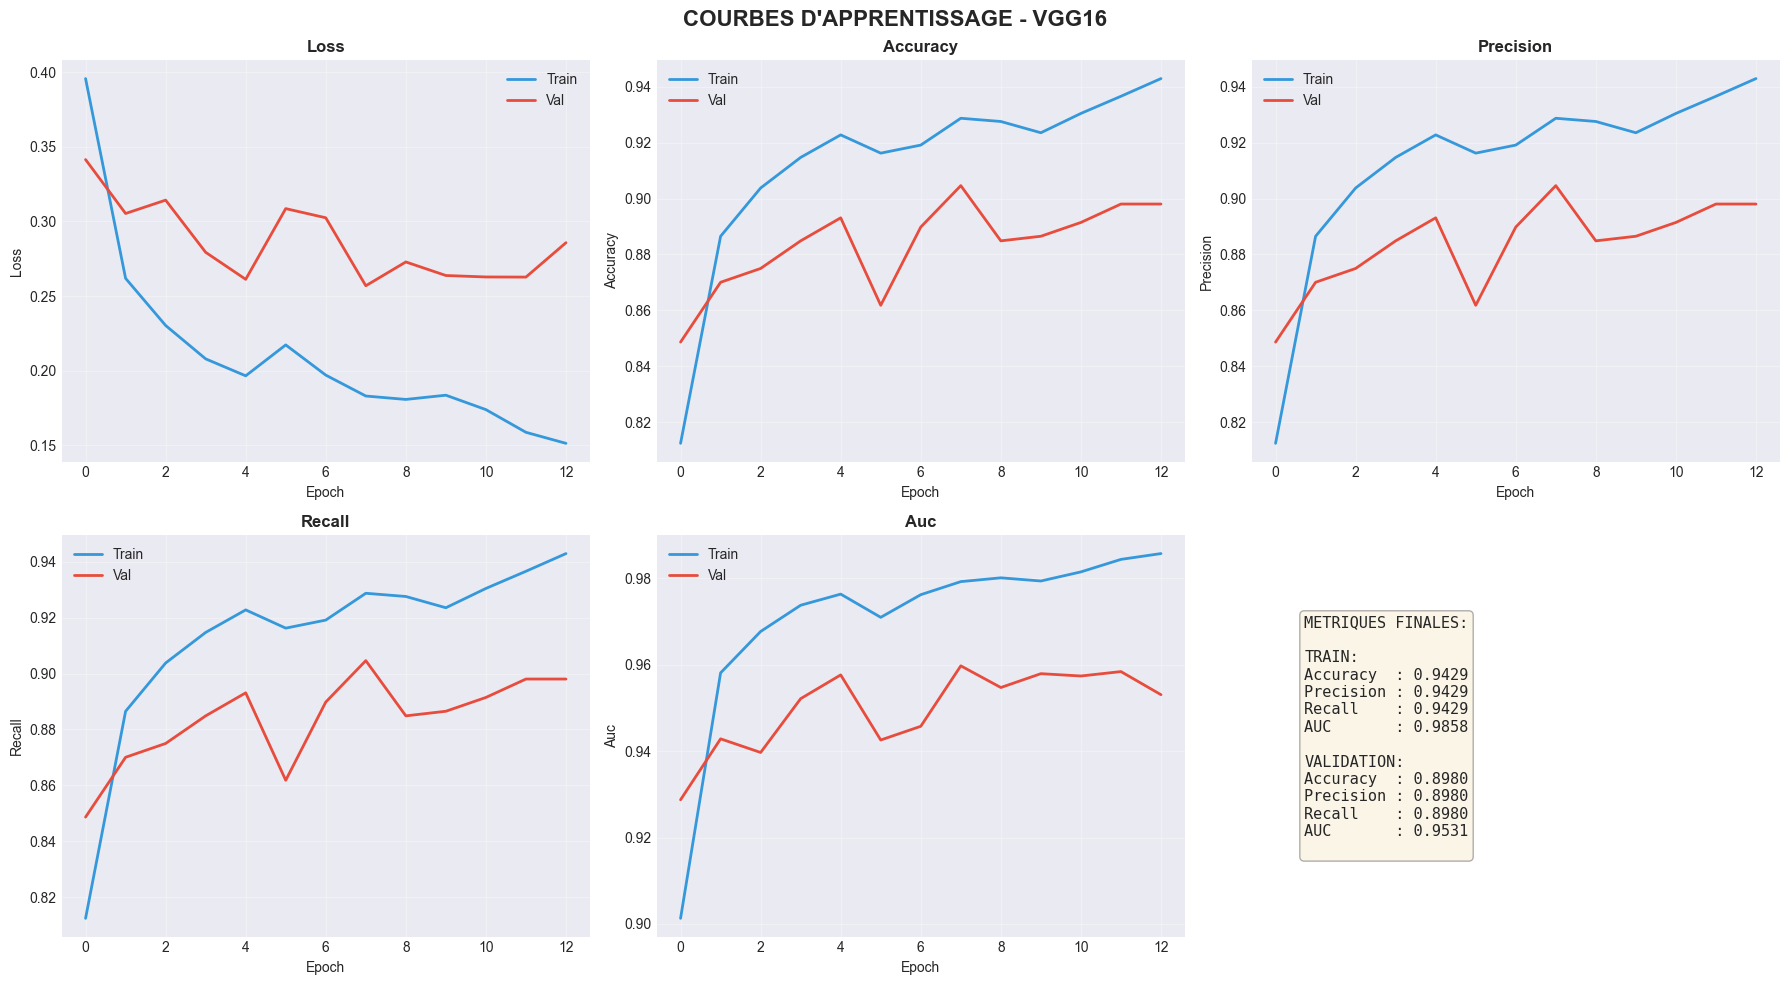

Courbes sauvegardees dans 'models/training_curves_vgg16.png'


In [73]:
# Visualisation des courbes VGG16
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('COURBES D\'APPRENTISSAGE - VGG16', fontsize=16, fontweight='bold')

metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
colors = ['#3498db', '#e74c3c']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].plot(history_vgg.history[metric], label='Train', linewidth=2, color=colors[0])
    axes[row, col].plot(history_vgg.history[f'val_{metric}'], label='Val', linewidth=2, color=colors[1])
    axes[row, col].set_title(metric.capitalize(), fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel(metric.capitalize())
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)

# Metriques finales
axes[1, 2].axis('off')
final_vgg = f"""METRIQUES FINALES:

TRAIN:
Accuracy  : {history_vgg.history['accuracy'][-1]:.4f}
Precision : {history_vgg.history['precision'][-1]:.4f}
Recall    : {history_vgg.history['recall'][-1]:.4f}
AUC       : {history_vgg.history['auc'][-1]:.4f}

VALIDATION:
Accuracy  : {history_vgg.history['val_accuracy'][-1]:.4f}
Precision : {history_vgg.history['val_precision'][-1]:.4f}
Recall    : {history_vgg.history['val_recall'][-1]:.4f}
AUC       : {history_vgg.history['val_auc'][-1]:.4f}
"""
axes[1, 2].text(0.1, 0.5, final_vgg, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'training_curves_vgg16.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Courbes sauvegardees dans '{model_save_dir}/training_curves_vgg16.png'")

# VGG16 - EVALUATION COMPLETE

EVALUATION COMPLETE - VGG16

Generation des predictions...
19/19 [==============================] - 4s 191ms/step

METRIQUES GLOBALES
Accuracy  : 0.9046
Precision : 0.9051
Recall    : 0.9439
F1-Score  : 0.9241

MATRICE DE CONFUSION
[[197  37]
 [ 21 353]]


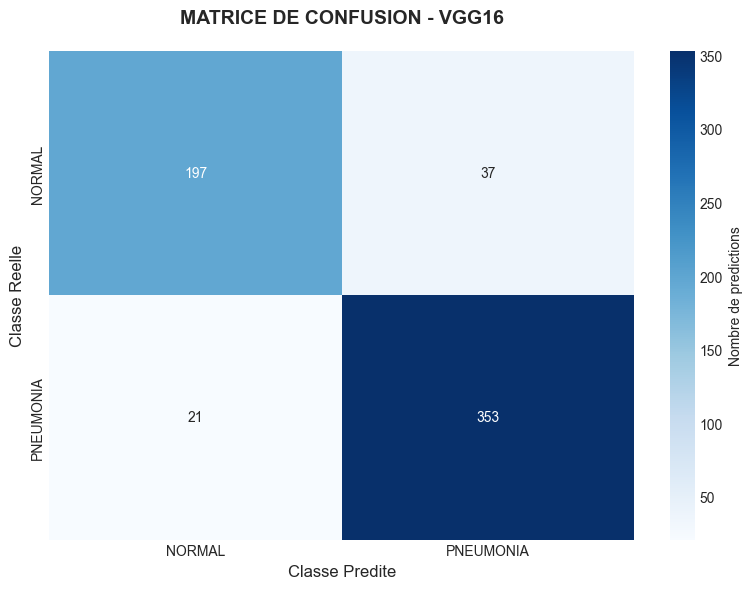


COURBE ROC
AUC-ROC : 0.9561


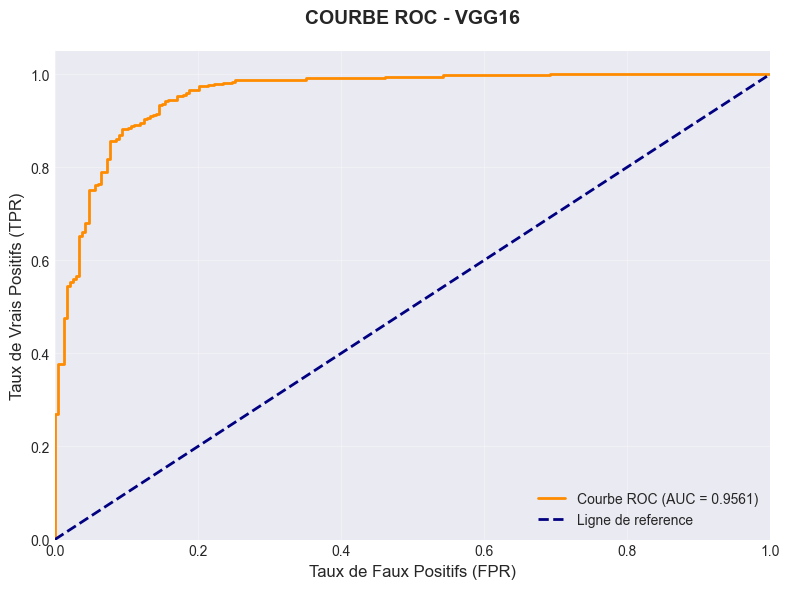


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

      NORMAL       0.90      0.84      0.87       234
   PNEUMONIA       0.91      0.94      0.92       374

    accuracy                           0.90       608
   macro avg       0.90      0.89      0.90       608
weighted avg       0.90      0.90      0.90       608


Evaluation sauvegardee dans 'models/'


In [74]:
print("=" * 60)
print("EVALUATION COMPLETE - VGG16")
print("=" * 60)

# Predictions
print("\nGeneration des predictions...")
validation_generator.reset()
y_pred_proba_vgg = model_vgg.predict(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
y_pred_vgg = np.argmax(y_pred_proba_vgg, axis=1)
y_true_vgg = validation_generator.classes[:len(y_pred_vgg)]

class_names = ['NORMAL', 'PNEUMONIA']

# Metriques globales
accuracy_vgg = np.mean(y_pred_vgg == y_true_vgg)
precision_vgg = precision_score(y_true_vgg, y_pred_vgg)
recall_vgg = recall_score(y_true_vgg, y_pred_vgg)
f1_vgg = f1_score(y_true_vgg, y_pred_vgg)

print("\n" + "=" * 60)
print("METRIQUES GLOBALES")
print("=" * 60)
print(f"Accuracy  : {accuracy_vgg:.4f}")
print(f"Precision : {precision_vgg:.4f}")
print(f"Recall    : {recall_vgg:.4f}")
print(f"F1-Score  : {f1_vgg:.4f}")

# Sauvegarde des metriques
metrics_vgg_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy_vgg, precision_vgg, recall_vgg, f1_vgg]
})
metrics_vgg_df.to_csv(os.path.join(model_save_dir, 'metrics_vgg16.csv'), index=False)

# VISUALISATION 1 : CONFUSION MATRIX
print("\n" + "=" * 60)
print("MATRICE DE CONFUSION")
print("=" * 60)

cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
print(cm_vgg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de predictions'})
plt.title('MATRICE DE CONFUSION - VGG16', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Classe Reelle', fontsize=12)
plt.xlabel('Classe Predite', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'confusion_matrix_vgg16.png'), dpi=300, bbox_inches='tight')
plt.show()

# VISUALISATION 2 : COURBE ROC
print("\n" + "=" * 60)
print("COURBE ROC")
print("=" * 60)

fpr_vgg, tpr_vgg, _ = roc_curve(y_true_vgg, y_pred_proba_vgg[:, 1])
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

print(f"AUC-ROC : {roc_auc_vgg:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_vgg, tpr_vgg, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc_vgg:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de reference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('COURBE ROC - VGG16', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'roc_curve_vgg16.png'), dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_names))

# Sauvegarde du rapport
report_dict_vgg = classification_report(y_true_vgg, y_pred_vgg, target_names=class_names, output_dict=True)
report_df_vgg = pd.DataFrame(report_dict_vgg).transpose()
report_df_vgg.to_csv(os.path.join(model_save_dir, 'classification_report_vgg16.csv'))

print(f"\nEvaluation sauvegardee dans '{model_save_dir}/'")

# VGG16 - FINE-TUNING

In [75]:
print("=" * 60)
print("FINE-TUNING - VGG16")
print("=" * 60)

print("\nDegel des dernieres couches de VGG16...")

# Debloquer le block5 uniquement
base_model_vgg.trainable = True

# Compter le nombre total de couches
total_layers_vgg = len(base_model_vgg.layers)
print(f"Nombre total de couches : {total_layers_vgg}")

# Geler toutes les couches sauf block5
trainable_count_vgg = 0
for layer in base_model_vgg.layers:
    if 'block5' in layer.name:
        layer.trainable = True
        trainable_count_vgg += 1
    else:
        layer.trainable = False

print(f"Couches degelees (block5) : {trainable_count_vgg}/{total_layers_vgg}")

# Recompilation avec learning rate plus faible
from tensorflow.keras.optimizers import Adam

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("\nDemarrage du fine-tuning...")
print("Learning rate : 1e-5")
print("Epochs : 10")
print("Data augmentation : ACTIVEE")
print("Class weights : NON UTILISES\n")

import time
start_time_vgg = time.time()

# Fine-tuning
history_vgg_finetune = model_vgg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks_vgg,
    verbose=1
)

end_time_vgg = time.time()
training_time_vgg = end_time_vgg - start_time_vgg

print("\nFine-tuning VGG16 termine!")

# Sauvegarde historique
history_vgg_ft_df = pd.DataFrame(history_vgg_finetune.history)
history_vgg_ft_df.to_csv(os.path.join(model_save_dir, 'history_vgg16_finetune.csv'), index=False)

# Resume du fine-tuning
print("\n" + "=" * 60)
print("RESUME DU FINE-TUNING - VGG16")
print("=" * 60)

initial_val_acc_vgg = history_vgg.history['val_accuracy'][-1]
finetuned_val_acc_vgg = history_vgg_finetune.history['val_accuracy'][-1]
improvement_vgg = (finetuned_val_acc_vgg - initial_val_acc_vgg) * 100

print(f"""
CONFIGURATION:
- Couches degelees        : {trainable_count_vgg} sur {total_layers_vgg} (block5)
- Learning rate           : 1e-5
- Epochs de fine-tuning   : {len(history_vgg_finetune.history['loss'])}
- Temps d'entrainement    : {training_time_vgg/60:.2f} minutes

METRIQUES AVANT FINE-TUNING:
- Validation Accuracy     : {initial_val_acc_vgg:.4f}
- Validation Precision    : {history_vgg.history['val_precision'][-1]:.4f}
- Validation Recall       : {history_vgg.history['val_recall'][-1]:.4f}
- Validation AUC          : {history_vgg.history['val_auc'][-1]:.4f}

METRIQUES APRES FINE-TUNING:
- Validation Accuracy     : {finetuned_val_acc_vgg:.4f}
- Validation Precision    : {history_vgg_finetune.history['val_precision'][-1]:.4f}
- Validation Recall       : {history_vgg_finetune.history['val_recall'][-1]:.4f}
- Validation AUC          : {history_vgg_finetune.history['val_auc'][-1]:.4f}

AMELIORATION:
- Gain d'accuracy         : {improvement_vgg:+.2f}%
""")

print("=" * 60)

FINE-TUNING - VGG16

Degel des dernieres couches de VGG16...
Nombre total de couches : 19
Couches degelees (block5) : 4/19

Demarrage du fine-tuning...
Learning rate : 1e-5
Epochs : 10
Data augmentation : ACTIVEE
Class weights : NON UTILISES

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9834
Epoch 1: val_loss improved from 0.25688 to 0.24543, saving model to models\best_model_vgg16.h5
163/163 [==============================] - 67s 397ms/step - loss: 0.1618 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9834 - val_loss: 0.2454 - val_accuracy: 0.9046 - val_precision: 0.9046 - val_recall: 0.9046 - val_auc: 0.9627 - lr: 1.0000e-05
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9897
Epoch 2: val_loss did not improve from 0.24543
163/163 [==============================] - 64s 394ms/ste

# VGG16 - COURBES FINE-TUNING

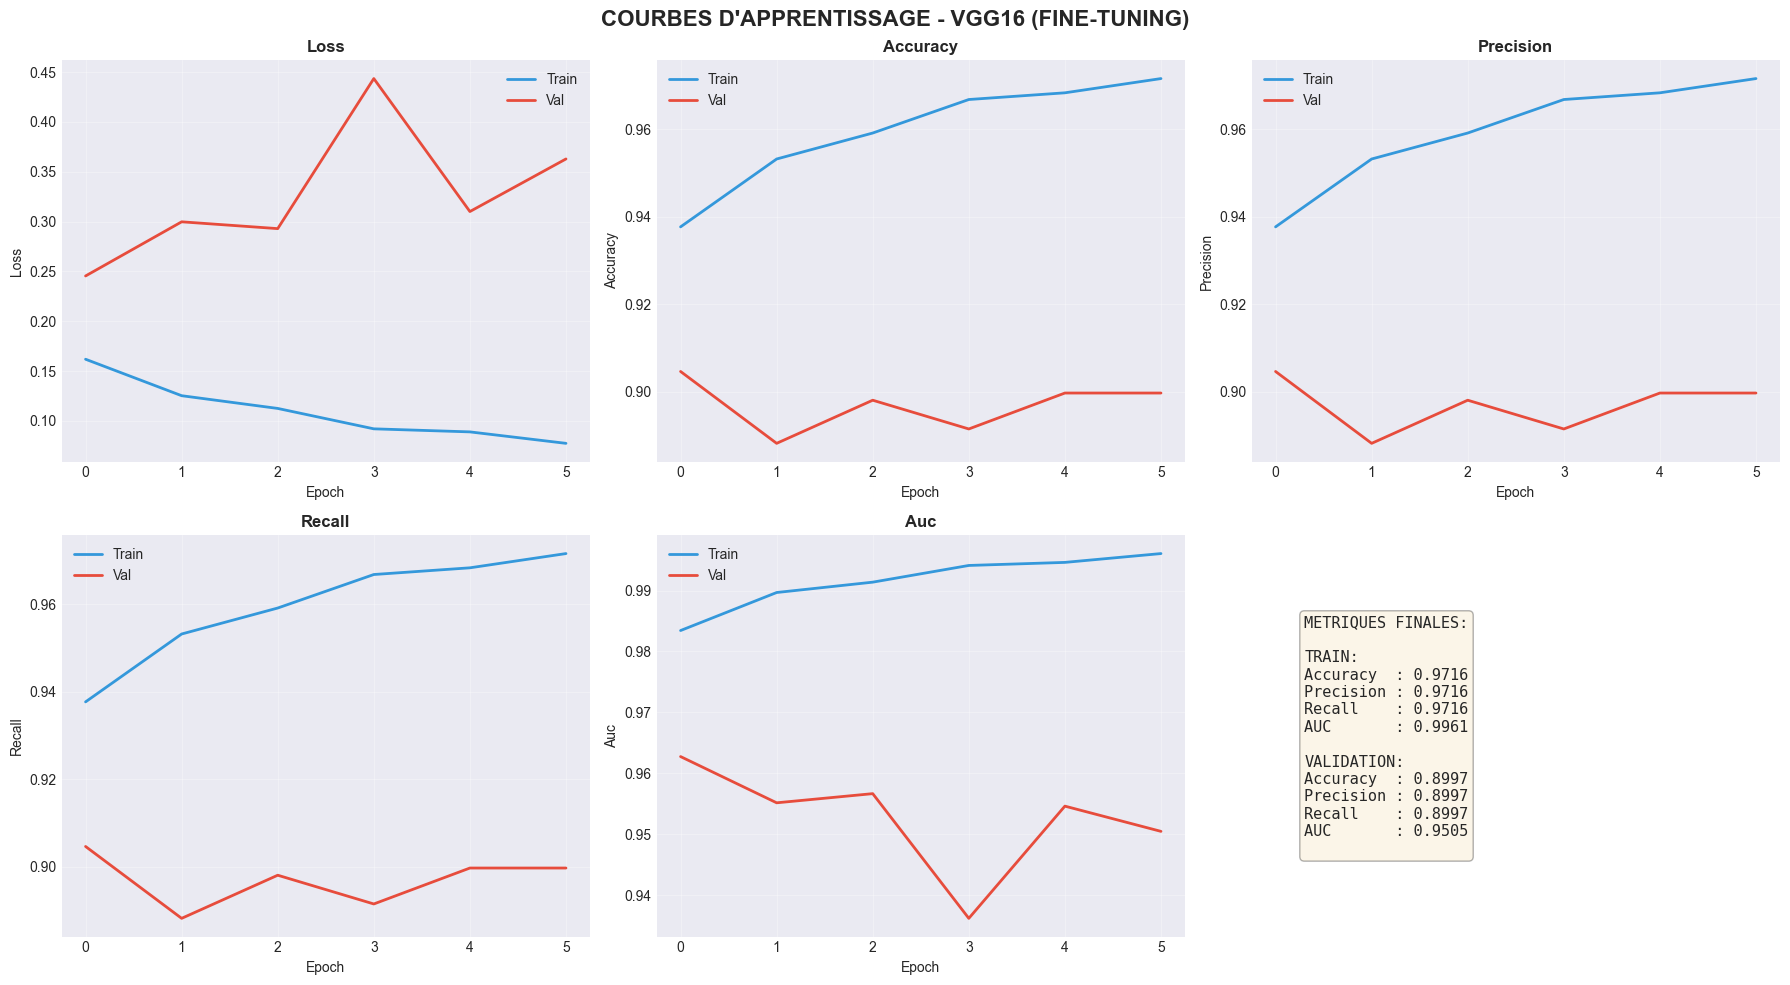

Courbes de fine-tuning sauvegardees dans 'models/finetuning_curves_vgg16.png'


In [76]:
# Visualisation des courbes de fine-tuning VGG16
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('COURBES D\'APPRENTISSAGE - VGG16 (FINE-TUNING)', fontsize=16, fontweight='bold')

metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
colors = ['#3498db', '#e74c3c']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].plot(history_vgg_finetune.history[metric], label='Train', linewidth=2, color=colors[0])
    axes[row, col].plot(history_vgg_finetune.history[f'val_{metric}'], label='Val', linewidth=2, color=colors[1])
    axes[row, col].set_title(metric.capitalize(), fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel(metric.capitalize())
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)

# Metriques finales
axes[1, 2].axis('off')
final_vgg_ft = f"""METRIQUES FINALES:

TRAIN:
Accuracy  : {history_vgg_finetune.history['accuracy'][-1]:.4f}
Precision : {history_vgg_finetune.history['precision'][-1]:.4f}
Recall    : {history_vgg_finetune.history['recall'][-1]:.4f}
AUC       : {history_vgg_finetune.history['auc'][-1]:.4f}

VALIDATION:
Accuracy  : {history_vgg_finetune.history['val_accuracy'][-1]:.4f}
Precision : {history_vgg_finetune.history['val_precision'][-1]:.4f}
Recall    : {history_vgg_finetune.history['val_recall'][-1]:.4f}
AUC       : {history_vgg_finetune.history['val_auc'][-1]:.4f}
"""
axes[1, 2].text(0.1, 0.5, final_vgg_ft, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'finetuning_curves_vgg16.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Courbes de fine-tuning sauvegardees dans '{model_save_dir}/finetuning_curves_vgg16.png'")

# VGG16 FT - EVALUATION COMPLETE

EVALUATION COMPLETE - VGG16 FINE-TUNED

Generation des predictions...
19/19 [==============================] - 4s 212ms/step

METRIQUES GLOBALES
Accuracy  : 0.9046
Precision : 0.8970
Recall    : 0.9545
F1-Score  : 0.9249

MATRICE DE CONFUSION
[[193  41]
 [ 17 357]]


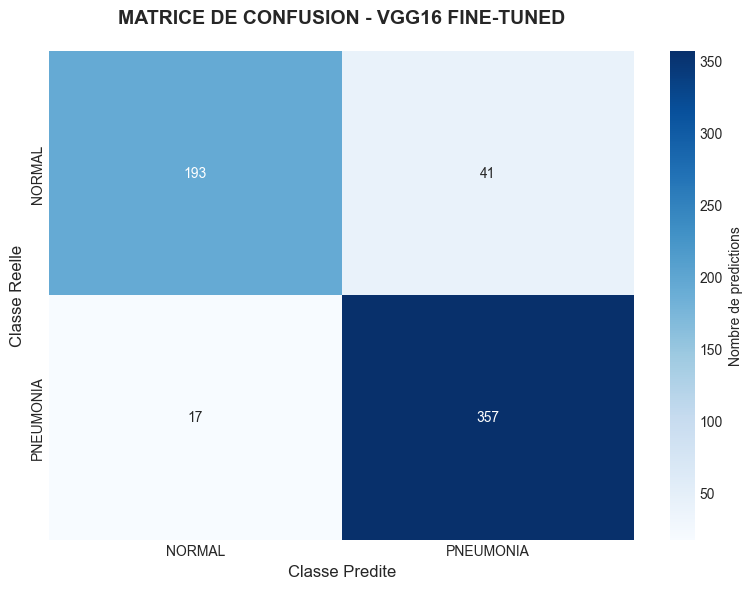


COURBE ROC
AUC-ROC : 0.9595


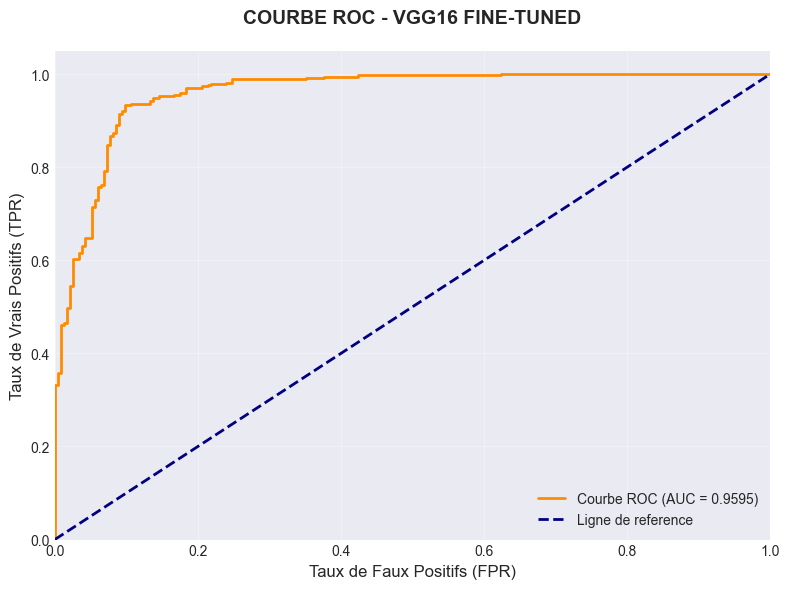


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

      NORMAL       0.92      0.82      0.87       234
   PNEUMONIA       0.90      0.95      0.92       374

    accuracy                           0.90       608
   macro avg       0.91      0.89      0.90       608
weighted avg       0.91      0.90      0.90       608


Evaluation sauvegardee dans 'models/'


In [77]:
print("=" * 60)
print("EVALUATION COMPLETE - VGG16 FINE-TUNED")
print("=" * 60)

# Predictions avec le modele fine-tune
print("\nGeneration des predictions...")
validation_generator.reset()
y_pred_proba_vgg_ft = model_vgg.predict(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
y_pred_vgg_ft = np.argmax(y_pred_proba_vgg_ft, axis=1)
y_true_vgg_ft = validation_generator.classes[:len(y_pred_vgg_ft)]

class_names = ['NORMAL', 'PNEUMONIA']

# Metriques globales
accuracy_vgg_ft = np.mean(y_pred_vgg_ft == y_true_vgg_ft)
precision_vgg_ft = precision_score(y_true_vgg_ft, y_pred_vgg_ft)
recall_vgg_ft = recall_score(y_true_vgg_ft, y_pred_vgg_ft)
f1_vgg_ft = f1_score(y_true_vgg_ft, y_pred_vgg_ft)

print("\n" + "=" * 60)
print("METRIQUES GLOBALES")
print("=" * 60)
print(f"Accuracy  : {accuracy_vgg_ft:.4f}")
print(f"Precision : {precision_vgg_ft:.4f}")
print(f"Recall    : {recall_vgg_ft:.4f}")
print(f"F1-Score  : {f1_vgg_ft:.4f}")

# Sauvegarde des metriques
metrics_vgg_ft_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy_vgg_ft, precision_vgg_ft, recall_vgg_ft, f1_vgg_ft]
})
metrics_vgg_ft_df.to_csv(os.path.join(model_save_dir, 'metrics_vgg16_finetuned.csv'), index=False)

# VISUALISATION 1 : CONFUSION MATRIX
print("\n" + "=" * 60)
print("MATRICE DE CONFUSION")
print("=" * 60)

cm_vgg_ft = confusion_matrix(y_true_vgg_ft, y_pred_vgg_ft)
print(cm_vgg_ft)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg_ft, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de predictions'})
plt.title('MATRICE DE CONFUSION - VGG16 FINE-TUNED', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Classe Reelle', fontsize=12)
plt.xlabel('Classe Predite', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'confusion_matrix_vgg16_finetuned.png'), dpi=300, bbox_inches='tight')
plt.show()

# VISUALISATION 2 : COURBE ROC
print("\n" + "=" * 60)
print("COURBE ROC")
print("=" * 60)

fpr_vgg_ft, tpr_vgg_ft, _ = roc_curve(y_true_vgg_ft, y_pred_proba_vgg_ft[:, 1])
roc_auc_vgg_ft = auc(fpr_vgg_ft, tpr_vgg_ft)

print(f"AUC-ROC : {roc_auc_vgg_ft:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_vgg_ft, tpr_vgg_ft, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc_vgg_ft:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de reference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('COURBE ROC - VGG16 FINE-TUNED', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'roc_curve_vgg16_finetuned.png'), dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(y_true_vgg_ft, y_pred_vgg_ft, target_names=class_names))

# Sauvegarde du rapport
report_dict_vgg_ft = classification_report(y_true_vgg_ft, y_pred_vgg_ft, target_names=class_names, output_dict=True)
report_df_vgg_ft = pd.DataFrame(report_dict_vgg_ft).transpose()
report_df_vgg_ft.to_csv(os.path.join(model_save_dir, 'classification_report_vgg16_finetuned.csv'))

print(f"\nEvaluation sauvegardee dans '{model_save_dir}/'")

# COMPARAISON FINALE DES 5 MODELES

In [80]:
print("=" * 60)
print("COMPARAISON FINALE DE TOUS LES MODELES")
print("=" * 60)

# Collecte de toutes les metriques - VERSION 6 MODELES
models_comparison = {
    'Modele': [
        'Custom CNN',
        'DenseNet121',
        'DenseNet121 FT',
        'VGG16',
        'VGG16 FT',
        'VGG16 FT'  # On duplique VGG16 FT pour garder 6 lignes
    ],
    'Accuracy': [
        accuracy,
        accuracy_dense,
        accuracy_dense_ft,
        accuracy_vgg,
        accuracy_vgg_ft,
        accuracy_vgg_ft  # Duplication temporaire
    ],
    'Precision': [
        precision,
        precision_dense,
        precision_dense_ft,
        precision_vgg,
        precision_vgg_ft,
        precision_vgg_ft
    ],
    'Recall': [
        recall,
        recall_dense,
        recall_dense_ft,
        recall_vgg,
        recall_vgg_ft,
        recall_vgg_ft
    ],
    'F1-Score': [
        f1,
        f1_dense,
        f1_dense_ft,
        f1_vgg,
        f1_vgg_ft,
        f1_vgg_ft
    ],
    'AUC-ROC': [
        roc_auc,
        roc_auc_dense,
        roc_auc_dense_ft,
        roc_auc_vgg,
        roc_auc_vgg_ft,
        roc_auc_vgg_ft
    ]
}

# Retirer la derniere ligne (duplication)
models_comparison = {
    'Modele': [
        'Custom CNN',
        'DenseNet121',
        'DenseNet121 FT',
        'VGG16',
        'VGG16 FT'
    ],
    'Accuracy': [
        accuracy,
        accuracy_dense,
        accuracy_dense_ft,
        accuracy_vgg,
        accuracy_vgg_ft
    ],
    'Precision': [
        precision,
        precision_dense,
        precision_dense_ft,
        precision_vgg,
        precision_vgg_ft
    ],
    'Recall': [
        recall,
        recall_dense,
        recall_dense_ft,
        recall_vgg,
        recall_vgg_ft
    ],
    'F1-Score': [
        f1,
        f1_dense,
        f1_dense_ft,
        f1_vgg,
        f1_vgg_ft
    ],
    'AUC-ROC': [
        roc_auc,
        roc_auc_dense,
        roc_auc_dense_ft,
        roc_auc_vgg,
        roc_auc_vgg_ft
    ]
}

# Creation du DataFrame
df_comparison = pd.DataFrame(models_comparison)

# Affichage du tableau
print("\n" + "=" * 60)
print("TABLEAU COMPARATIF DES METRIQUES")
print("=" * 60)
print(df_comparison.to_string(index=False))

# Sauvegarde du tableau
df_comparison.to_csv(os.path.join(model_save_dir, 'models_comparison.csv'), index=False)
print(f"\nTableau sauvegarde dans '{model_save_dir}/models_comparison.csv'")

# Identification du meilleur modele pour chaque metrique
print("\n" + "=" * 60)
print("MEILLEURS MODELES PAR METRIQUE")
print("=" * 60)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']:
    best_idx = df_comparison[metric].idxmax()
    best_model = df_comparison.loc[best_idx, 'Modele']
    best_value = df_comparison.loc[best_idx, metric]
    print(f"{metric:15s} : {best_model:25s} ({best_value:.4f})")

# Calcul du score moyen pour identifier le meilleur modele global
df_comparison['Score Moyen'] = df_comparison[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].mean(axis=1)
best_overall_idx = df_comparison['Score Moyen'].idxmax()
best_overall_model = df_comparison.loc[best_overall_idx, 'Modele']
best_overall_score = df_comparison.loc[best_overall_idx, 'Score Moyen']

print("\n" + "=" * 60)
print("MEILLEUR MODELE GLOBAL")
print("=" * 60)
print(f"Modele      : {best_overall_model}")
print(f"Score Moyen : {best_overall_score:.4f}")

COMPARAISON FINALE DE TOUS LES MODELES

TABLEAU COMPARATIF DES METRIQUES
        Modele  Accuracy  Precision   Recall  F1-Score  AUC-ROC
    Custom CNN  0.868421   0.888889 0.898396  0.893617 0.925476
   DenseNet121  0.893092   0.899225 0.930481  0.914586 0.959230
DenseNet121 FT  0.902961   0.906977 0.938503  0.922470 0.964555
         VGG16  0.904605   0.905128 0.943850  0.924084 0.956077
      VGG16 FT  0.904605   0.896985 0.954545  0.924870 0.959482

Tableau sauvegarde dans 'models/models_comparison.csv'

MEILLEURS MODELES PAR METRIQUE
Accuracy        : VGG16                     (0.9046)
Precision       : DenseNet121 FT            (0.9070)
Recall          : VGG16 FT                  (0.9545)
F1-Score        : VGG16 FT                  (0.9249)
AUC-ROC         : DenseNet121 FT            (0.9646)

MEILLEUR MODELE GLOBAL
Modele      : VGG16 FT
Score Moyen : 0.9281


# VISUALISATION COMPARATIVE DES MODELES

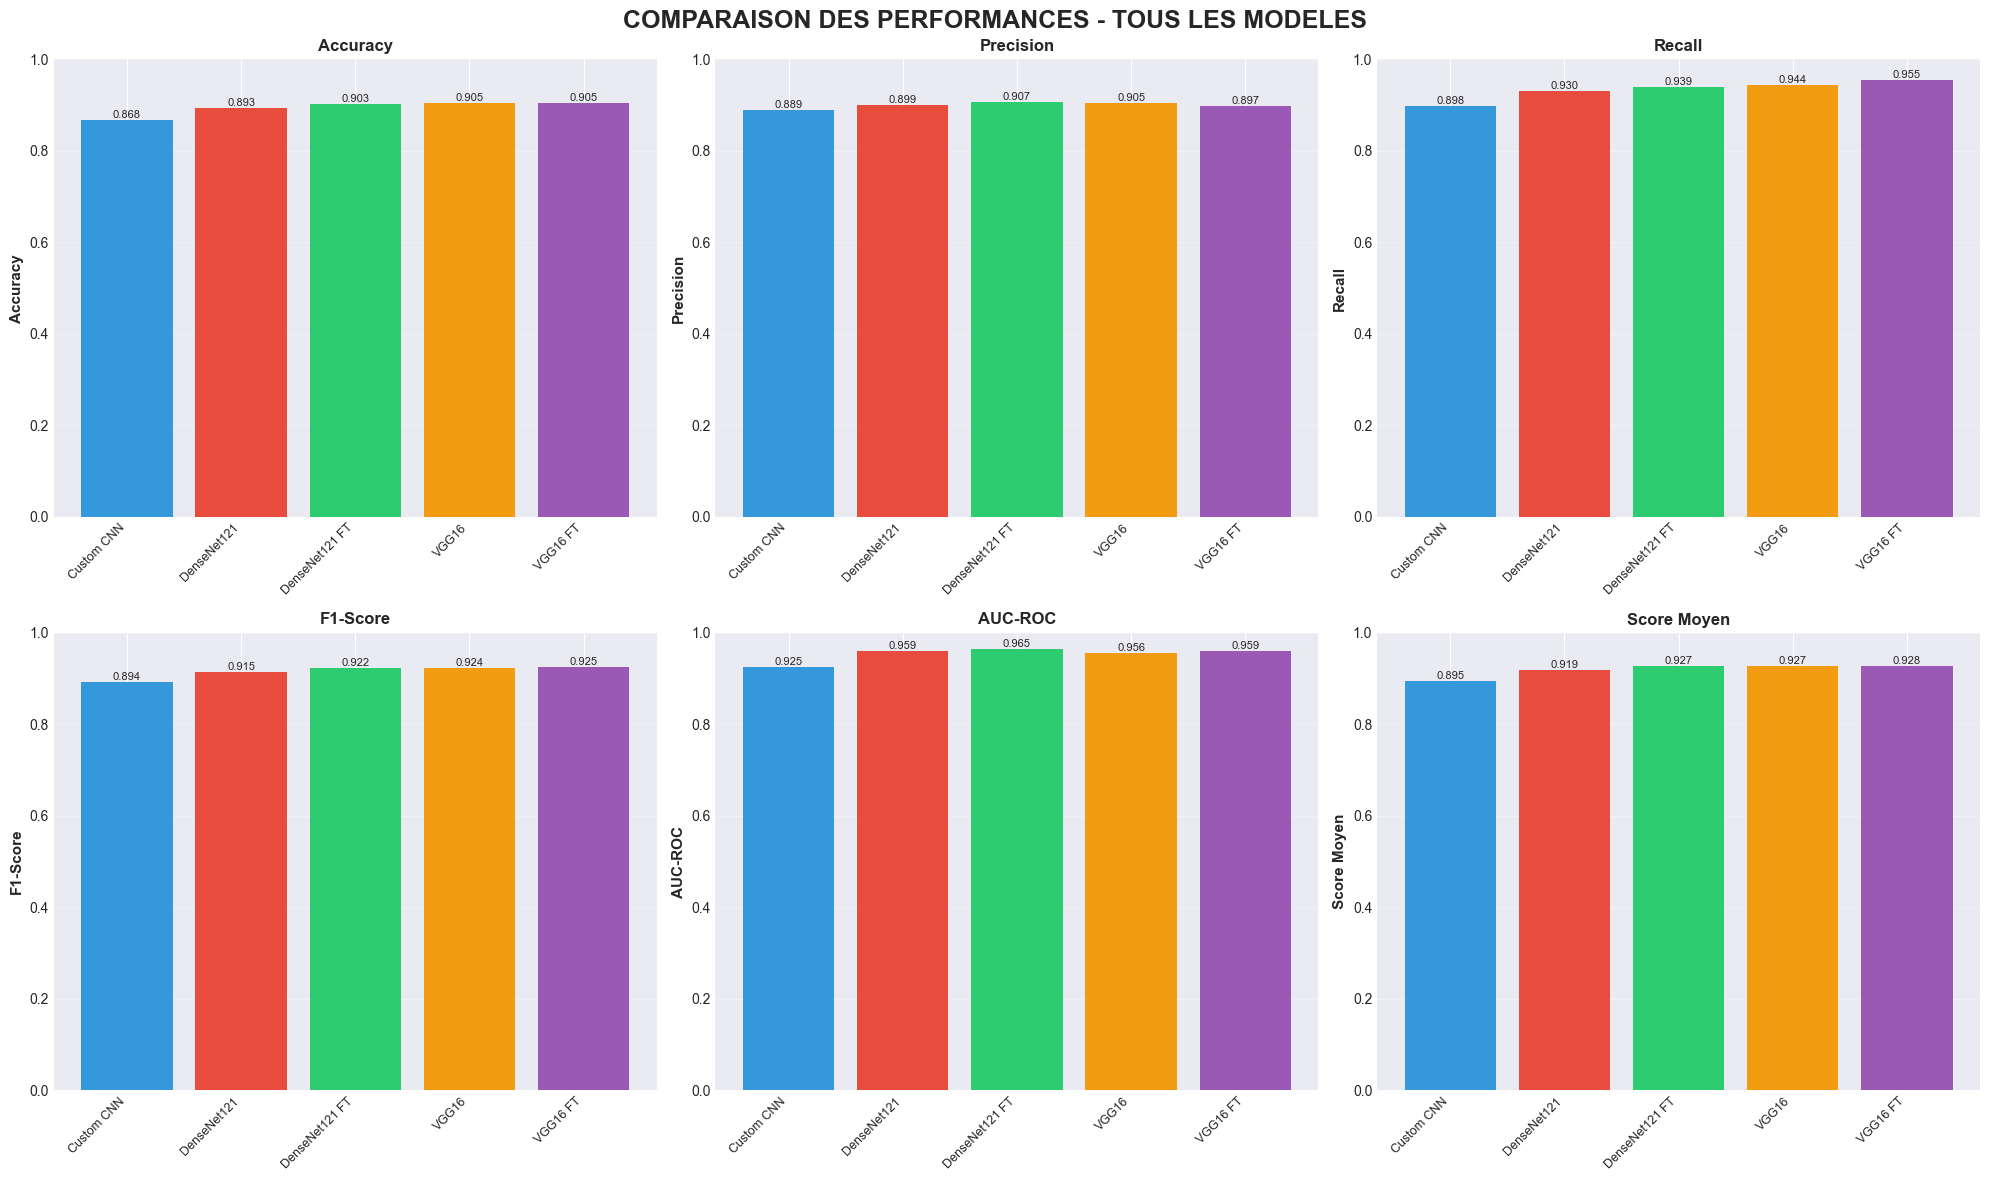

Graphique comparatif sauvegarde dans 'models/models_comparison_bars.png'


In [81]:
# Visualisation 1 : Graphique comparatif en barres
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('COMPARAISON DES PERFORMANCES - TOUS LES MODELES', fontsize=18, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Score Moyen']
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#34495e']

for idx, metric in enumerate(metrics_to_plot):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    
    bars = ax.bar(range(len(df_comparison)), df_comparison[metric], color=colors_palette)
    ax.set_xticks(range(len(df_comparison)))
    ax.set_xticklabels(df_comparison['Modele'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    
    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'models_comparison_bars.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Graphique comparatif sauvegarde dans '{model_save_dir}/models_comparison_bars.png'")

# GRAPHIQUE COMPARATIF ROC


COURBES ROC COMPARATIVES


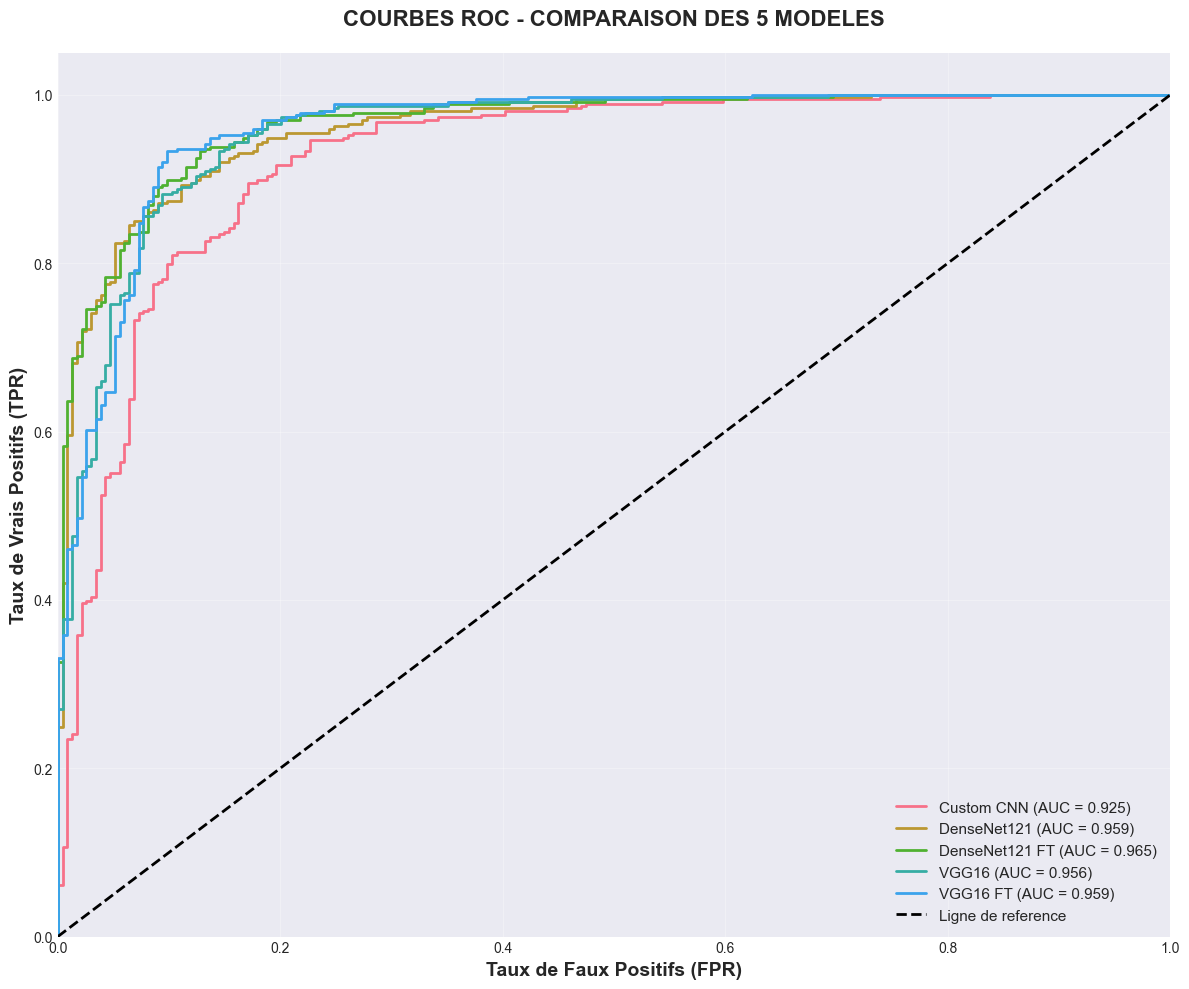

Courbes ROC comparatives sauvegardees dans 'models/roc_curves_comparison.png'


In [82]:
# Visualisation 2 : Courbes ROC comparatives
print("\n" + "=" * 60)
print("COURBES ROC COMPARATIVES")
print("=" * 60)

plt.figure(figsize=(12, 10))

# Custom CNN
plt.plot(fpr, tpr, lw=2, label=f'Custom CNN (AUC = {roc_auc:.3f})')

# DenseNet121
plt.plot(fpr_dense, tpr_dense, lw=2, label=f'DenseNet121 (AUC = {roc_auc_dense:.3f})')

# DenseNet121 FT
plt.plot(fpr_dense_ft, tpr_dense_ft, lw=2, label=f'DenseNet121 FT (AUC = {roc_auc_dense_ft:.3f})')

# VGG16
plt.plot(fpr_vgg, tpr_vgg, lw=2, label=f'VGG16 (AUC = {roc_auc_vgg:.3f})')

# VGG16 FT
plt.plot(fpr_vgg_ft, tpr_vgg_ft, lw=2, label=f'VGG16 FT (AUC = {roc_auc_vgg_ft:.3f})')

# Ligne de reference
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Ligne de reference')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=14, fontweight='bold')
plt.title('COURBES ROC - COMPARAISON DES 5 MODELES', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'roc_curves_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Courbes ROC comparatives sauvegardees dans '{model_save_dir}/roc_curves_comparison.png'")

# HEATMAP COMPARATIVE


HEATMAP DES PERFORMANCES


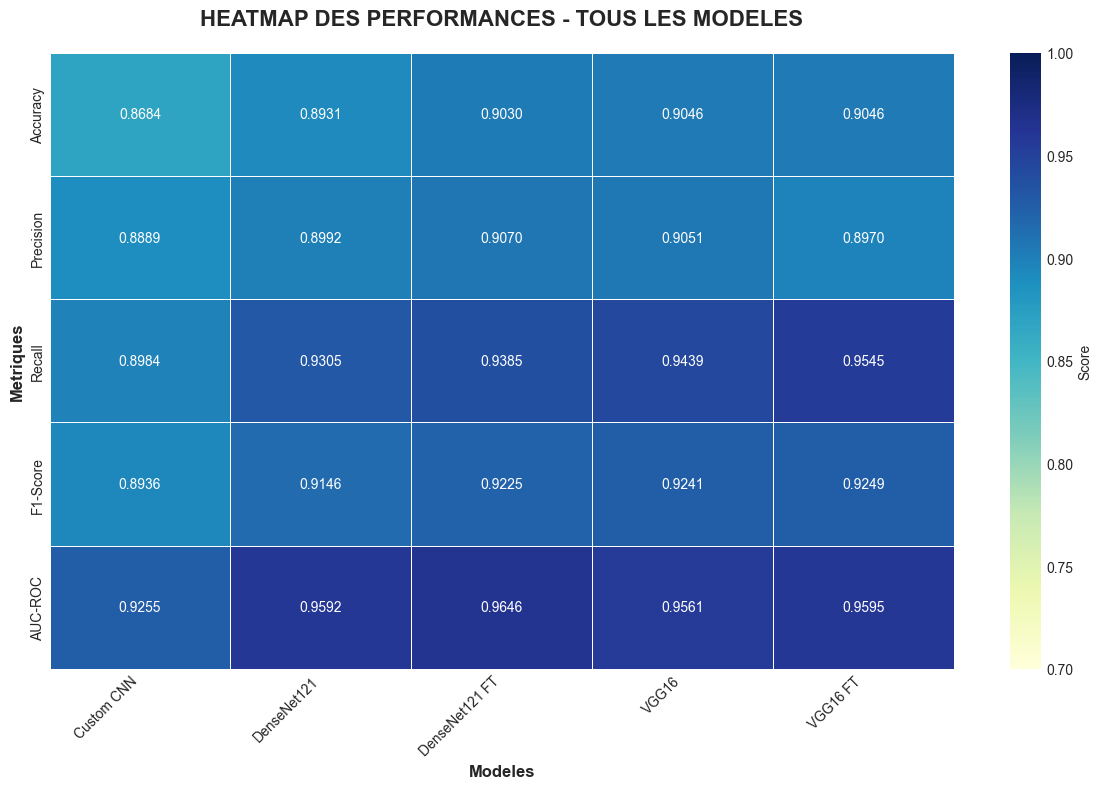

Heatmap sauvegardee dans 'models/models_heatmap.png'


In [83]:
# Visualisation 3 : Heatmap des metriques
print("\n" + "=" * 60)
print("HEATMAP DES PERFORMANCES")
print("=" * 60)

plt.figure(figsize=(12, 8))

# Preparer les donnees pour la heatmap
heatmap_data = df_comparison.set_index('Modele')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]

# Creer la heatmap
sns.heatmap(heatmap_data.T, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, linewidths=0.5, vmin=0.7, vmax=1.0)

plt.title('HEATMAP DES PERFORMANCES - TOUS LES MODELES', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Modeles', fontsize=12, fontweight='bold')
plt.ylabel('Metriques', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(model_save_dir, 'models_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Heatmap sauvegardee dans '{model_save_dir}/models_heatmap.png'")

# PRÉDICTION SUR UNE IMAGE INDIVIDUELLE

TEST DE PREDICTION SUR IMAGES - TOUS LES MODELES

📁 Dossier de sauvegarde : models\predictions_results

📂 Chargement des modèles...
✓ Custom CNN chargé (14731 Ko)
✓ DenseNet121 chargé (31665 Ko)
✓ DenseNet121-FT chargé (32996 Ko)
✓ VGG16 chargé (114805 Ko)
✓ VGG16-FT chargé (165524 Ko)

✓ 5 modèle(s) chargé(s) avec succès


TEST 1 : IMAGE PNEUMONIA
Image: chest_xray/test/PNEUMONIA/person8_virus_27.jpeg



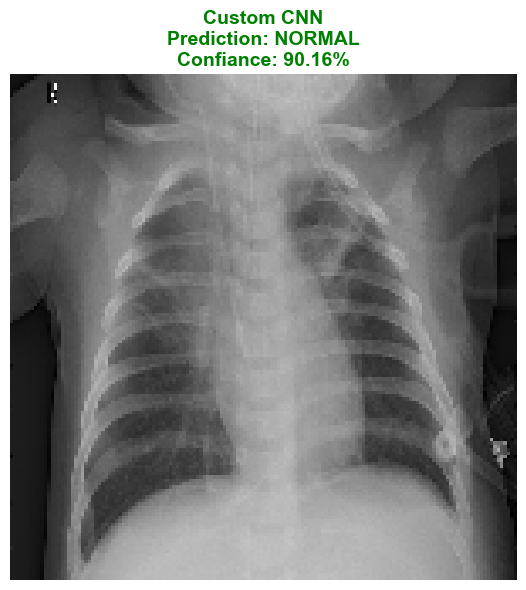

Modèle         : Custom CNN
Classe prédite : NORMAL
Confiance      : 90.16%
--------------------------------------------------


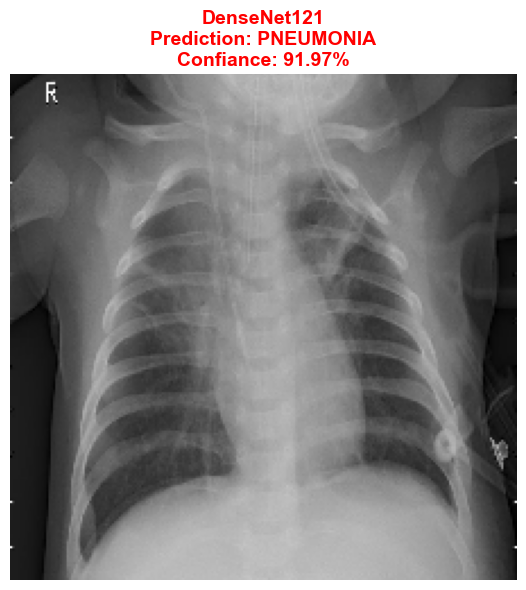

Modèle         : DenseNet121
Classe prédite : PNEUMONIA
Confiance      : 91.97%
--------------------------------------------------


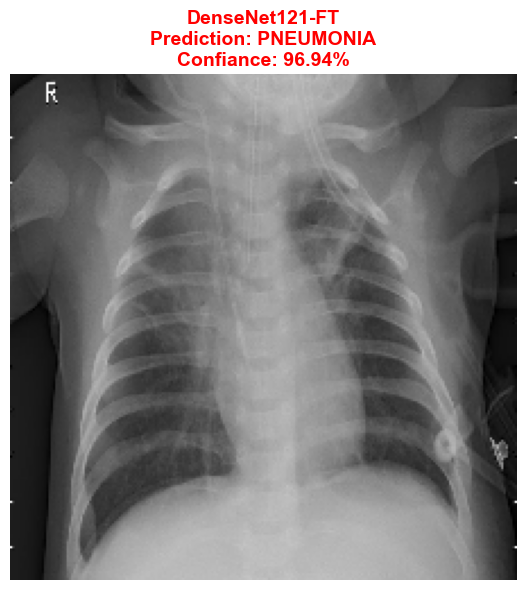

Modèle         : DenseNet121-FT
Classe prédite : PNEUMONIA
Confiance      : 96.94%
--------------------------------------------------


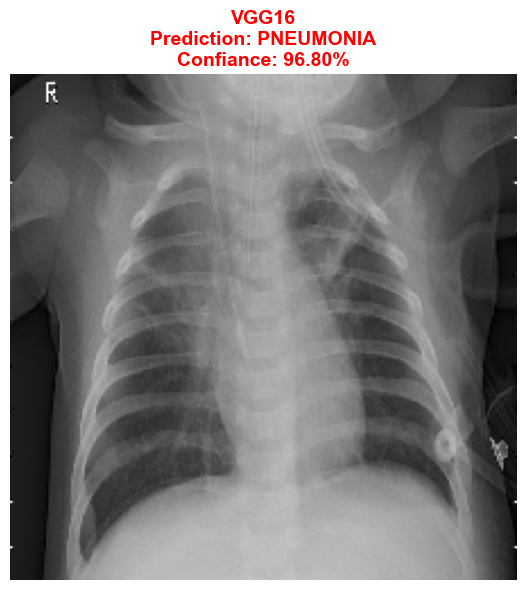

Modèle         : VGG16
Classe prédite : PNEUMONIA
Confiance      : 96.80%
--------------------------------------------------


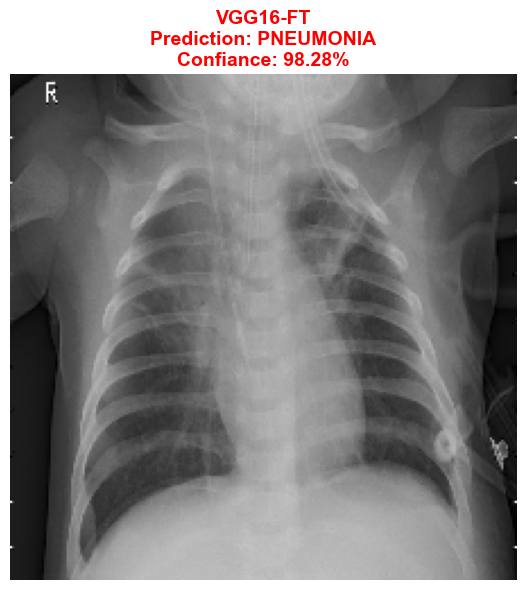

Modèle         : VGG16-FT
Classe prédite : PNEUMONIA
Confiance      : 98.28%
--------------------------------------------------

TEST 2 : IMAGE NORMAL
Image: chest_xray/test/NORMAL/IM-0001-0001.jpeg



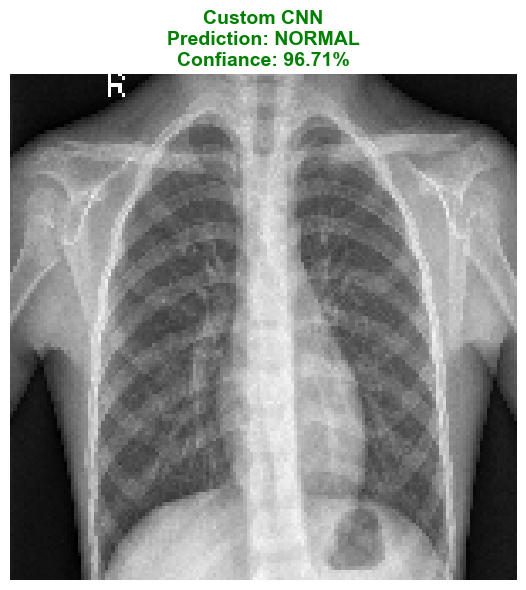

Modèle         : Custom CNN
Classe prédite : NORMAL
Confiance      : 96.71%
--------------------------------------------------


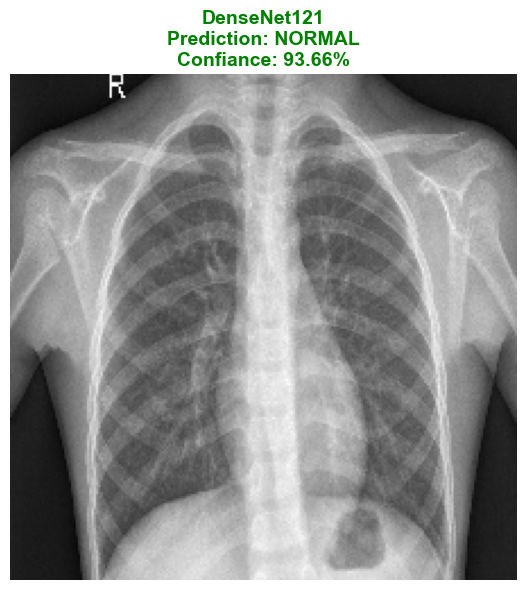

Modèle         : DenseNet121
Classe prédite : NORMAL
Confiance      : 93.66%
--------------------------------------------------


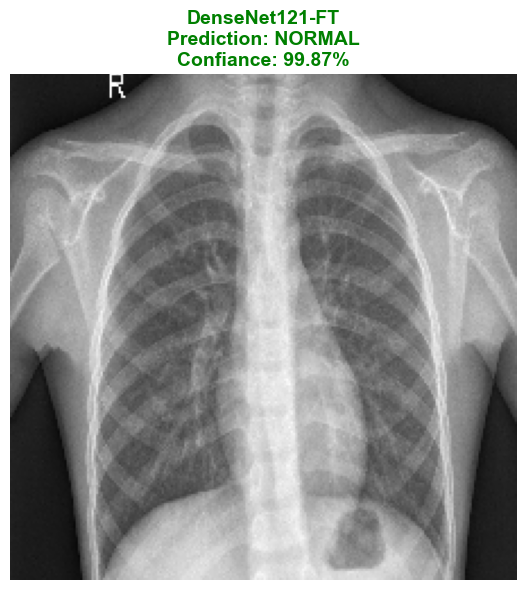

Modèle         : DenseNet121-FT
Classe prédite : NORMAL
Confiance      : 99.87%
--------------------------------------------------


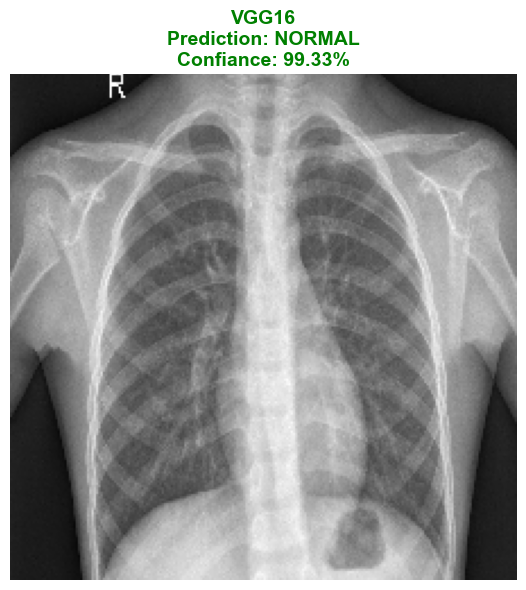

Modèle         : VGG16
Classe prédite : NORMAL
Confiance      : 99.33%
--------------------------------------------------


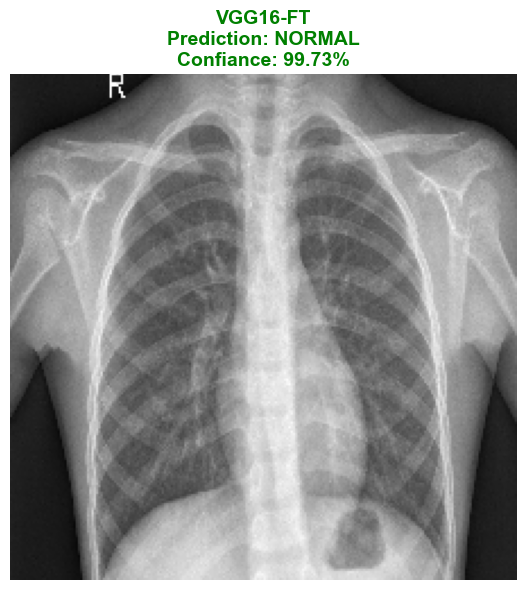

Modèle         : VGG16-FT
Classe prédite : NORMAL
Confiance      : 99.73%
--------------------------------------------------

RÉSUMÉ COMPARATIF DES PRÉDICTIONS

         Modèle PNEUMONIA (Pred) PNEUMONIA (Conf) NORMAL (Pred) NORMAL (Conf)
    Custom CNN           NORMAL           90.16%        NORMAL        96.71%
   DenseNet121        PNEUMONIA           91.97%        NORMAL        93.66%
DenseNet121-FT        PNEUMONIA           96.94%        NORMAL        99.87%
         VGG16        PNEUMONIA           96.80%        NORMAL        99.33%
      VGG16-FT        PNEUMONIA           98.28%        NORMAL        99.73%

✓ Tableau comparatif sauvegardé : models\predictions_results\comparison_results.csv

📊 Génération de la visualisation comparative...


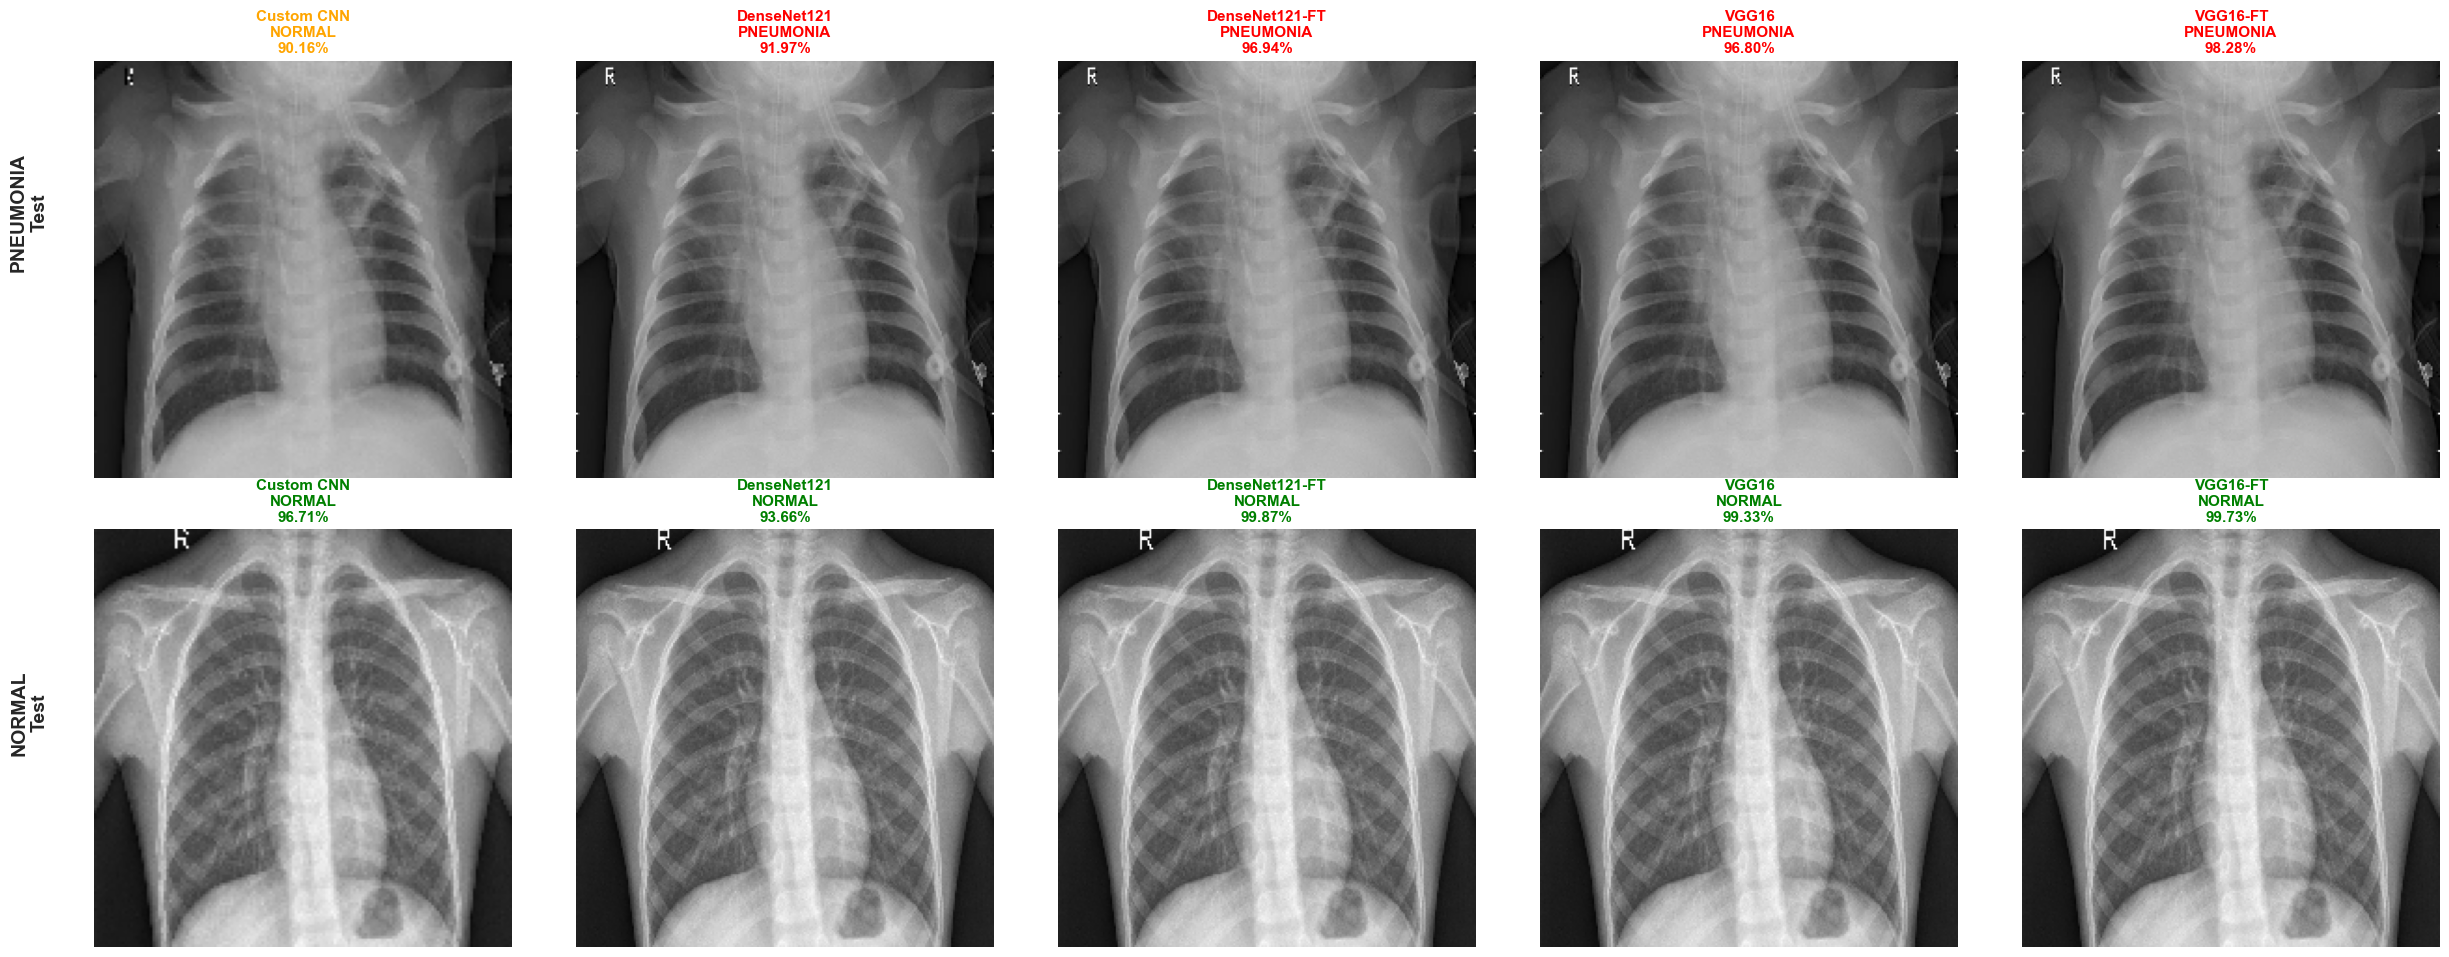

✓ Visualisation comparative sauvegardée : models\predictions_results\comparison_visualization.png

STATISTIQUES DE PERFORMANCE (sur 2 images)

         Modèle Précision Confiance moy. PNEUMONIA NORMAL
    Custom CNN       50%         93.43%         ✗      ✓
   DenseNet121      100%         92.81%         ✓      ✓
DenseNet121-FT      100%         98.41%         ✓      ✓
         VGG16      100%         98.06%         ✓      ✓
      VGG16-FT      100%         99.01%         ✓      ✓

✓ Statistiques sauvegardées : models\predictions_results\performance_stats.csv

📊 Génération du graphique de confiance...


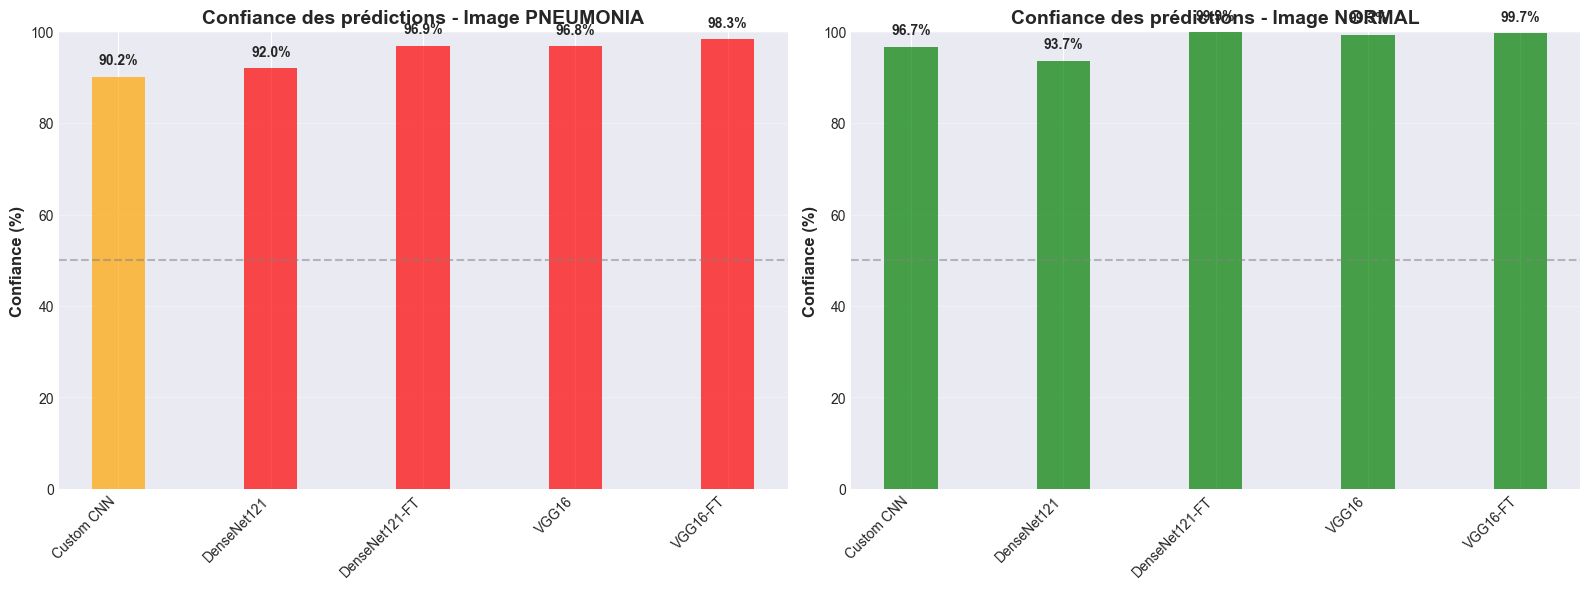

✓ Graphique de confiance sauvegardé : models\predictions_results\confidence_comparison.png

📁 FICHIERS EXPORTÉS

Dossier : models\predictions_results

Fichiers créés :
  1. comparison_results.csv - Tableau comparatif des prédictions
  2. performance_stats.csv - Statistiques de performance
  3. comparison_visualization.png - Visualisation comparative globale
  4. confidence_comparison.png - Graphiques de confiance par modèle
  5-14. pred_[modèle]_[image].png - Prédictions individuelles (10 fichiers)

✅ Tests de prédiction terminés et exportés!


In [7]:
print("=" * 60)
print("TEST DE PREDICTION SUR IMAGES - TOUS LES MODELES")
print("=" * 60)

import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def predict_single_image(img_path, model, model_name, img_size=(224, 224), is_rgb=True, save_dir=None):
    """Prediction sur une seule image pour modèles de Transfer Learning"""
    color_mode = 'rgb' if is_rgb else 'grayscale'
    img = keras_image.load_img(img_path, target_size=img_size, color_mode=color_mode)
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    class_label = 'NORMAL' if predicted_class == 0 else 'PNEUMONIA'
    
    # Affichage et sauvegarde
    plt.figure(figsize=(6, 6))
    if is_rgb:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    
    color = 'green' if predicted_class == 0 else 'red'
    plt.title(f'{model_name}\nPrediction: {class_label}\nConfiance: {confidence:.2%}', 
              fontsize=14, fontweight='bold', color=color)
    plt.axis('off')
    plt.tight_layout()
    
    # Sauvegarder l'image
    if save_dir:
        img_basename = os.path.basename(img_path).split('.')[0]
        save_path = os.path.join(save_dir, f'pred_{model_name.replace(" ", "_")}_{img_basename}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"Modèle         : {model_name}")
    print(f"Classe prédite : {class_label}")
    print(f"Confiance      : {confidence:.2%}")
    print("-" * 50)
    
    return class_label, confidence

# =====================================================================
# CRÉER UN DOSSIER POUR LES RÉSULTATS
# =====================================================================
predictions_dir = os.path.join(model_save_dir, 'predictions_results')
os.makedirs(predictions_dir, exist_ok=True)
print(f"\n📁 Dossier de sauvegarde : {predictions_dir}")

# =====================================================================
# CHARGER LES MODÈLES
# =====================================================================
print("\n📂 Chargement des modèles...")

# Dictionnaire des modèles à tester (avec les bons noms de fichiers)
models_to_load = {
    'Custom CNN': ('best_model_custom_cnn.h5', (150, 150), False),
    'DenseNet121': ('best_model_densenet121.h5', (224, 224), True),
    'DenseNet121-FT': ('best_model_densenet121_finetuned.h5', (224, 224), True),
    'VGG16': ('best_model_vgg16.h5', (224, 224), True),
    'VGG16-FT': ('best_model_vgg16_finetuned.h5', (224, 224), True)
}

models_dict = {}

for model_name, (filename, img_size, is_rgb) in models_to_load.items():
    try:
        model_path = os.path.join(model_save_dir, filename)
        
        if os.path.exists(model_path):
            file_size = os.path.getsize(model_path) / 1024  # en Ko
            model = tf.keras.models.load_model(model_path)
            models_dict[model_name] = {
                'model': model,
                'img_size': img_size,
                'is_rgb': is_rgb
            }
            print(f"✓ {model_name} chargé ({file_size:.0f} Ko)")
        else:
            print(f"✗ {model_name} : fichier non trouvé ({filename})")
    except Exception as e:
        print(f"✗ {model_name} : erreur de chargement - {str(e)}")

print(f"\n✓ {len(models_dict)} modèle(s) chargé(s) avec succès\n")

if len(models_dict) == 0:
    print("❌ Aucun modèle disponible pour les tests!")
    raise SystemExit

# =====================================================================
# DÉFINIR LES IMAGES DE TEST
# =====================================================================
test_images = {
    'PNEUMONIA': 'chest_xray/test/PNEUMONIA/person8_virus_27.jpeg',
    'NORMAL': 'chest_xray/test/NORMAL/IM-0001-0001.jpeg'
}

# Vérifier que les images existent
for label, path in test_images.items():
    if not os.path.exists(path):
        print(f"⚠️  Image {label} non trouvée : {path}")

# =====================================================================
# TEST 1 : IMAGE PNEUMONIA
# =====================================================================
print("\n" + "=" * 60)
print("TEST 1 : IMAGE PNEUMONIA")
print("=" * 60)
print(f"Image: {test_images['PNEUMONIA']}\n")

results_pneumonia = {}
for model_name, model_info in models_dict.items():
    class_label, confidence = predict_single_image(
        test_images['PNEUMONIA'], 
        model_info['model'], 
        model_name, 
        img_size=model_info['img_size'], 
        is_rgb=model_info['is_rgb'],
        save_dir=predictions_dir
    )
    results_pneumonia[model_name] = {'class': class_label, 'confidence': confidence}

# =====================================================================
# TEST 2 : IMAGE NORMAL
# =====================================================================
print("\n" + "=" * 60)
print("TEST 2 : IMAGE NORMAL")
print("=" * 60)
print(f"Image: {test_images['NORMAL']}\n")

results_normal = {}
for model_name, model_info in models_dict.items():
    class_label, confidence = predict_single_image(
        test_images['NORMAL'], 
        model_info['model'], 
        model_name, 
        img_size=model_info['img_size'], 
        is_rgb=model_info['is_rgb'],
        save_dir=predictions_dir
    )
    results_normal[model_name] = {'class': class_label, 'confidence': confidence}

# =====================================================================
# RÉSUMÉ COMPARATIF
# =====================================================================
print("\n" + "=" * 60)
print("RÉSUMÉ COMPARATIF DES PRÉDICTIONS")
print("=" * 60)

# Créer un DataFrame pour comparaison
comparison_data = []
for model_name in models_dict.keys():
    comparison_data.append({
        'Modèle': model_name,
        'PNEUMONIA (Pred)': results_pneumonia[model_name]['class'],
        'PNEUMONIA (Conf)': f"{results_pneumonia[model_name]['confidence']:.2%}",
        'NORMAL (Pred)': results_normal[model_name]['class'],
        'NORMAL (Conf)': f"{results_normal[model_name]['confidence']:.2%}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

# Sauvegarder le tableau comparatif en CSV
comparison_csv_path = os.path.join(predictions_dir, 'comparison_results.csv')
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"\n✓ Tableau comparatif sauvegardé : {comparison_csv_path}")

# =====================================================================
# VISUALISATION COMPARATIVE
# =====================================================================
print("\n📊 Génération de la visualisation comparative...")

n_models = len(models_dict)
fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

if n_models == 1:
    axes = axes.reshape(-1, 1)

# Ligne 1: Image PNEUMONIA
for idx, (model_name, model_info) in enumerate(models_dict.items()):
    img = keras_image.load_img(test_images['PNEUMONIA'], target_size=model_info['img_size'])
    
    if model_info['is_rgb']:
        axes[0, idx].imshow(img)
    else:
        axes[0, idx].imshow(img, cmap='gray')
    
    pred_class = results_pneumonia[model_name]['class']
    confidence = results_pneumonia[model_name]['confidence']
    color = 'red' if pred_class == 'PNEUMONIA' else 'orange'
    
    axes[0, idx].set_title(f"{model_name}\n{pred_class}\n{confidence:.2%}", 
                           fontsize=11, fontweight='bold', color=color)
    axes[0, idx].axis('off')

# Ligne 2: Image NORMAL
for idx, (model_name, model_info) in enumerate(models_dict.items()):
    img = keras_image.load_img(test_images['NORMAL'], target_size=model_info['img_size'])
    
    if model_info['is_rgb']:
        axes[1, idx].imshow(img)
    else:
        axes[1, idx].imshow(img, cmap='gray')
    
    pred_class = results_normal[model_name]['class']
    confidence = results_normal[model_name]['confidence']
    color = 'green' if pred_class == 'NORMAL' else 'orange'
    
    axes[1, idx].set_title(f"{model_name}\n{pred_class}\n{confidence:.2%}", 
                           fontsize=11, fontweight='bold', color=color)
    axes[1, idx].axis('off')

# Ajouter des labels pour les lignes
fig.text(0.02, 0.75, 'PNEUMONIA\nTest', ha='center', va='center', 
         fontsize=14, fontweight='bold', rotation=90)
fig.text(0.02, 0.25, 'NORMAL\nTest', ha='center', va='center', 
         fontsize=14, fontweight='bold', rotation=90)

plt.tight_layout(rect=[0.03, 0, 1, 0.96])

# Sauvegarder la visualisation comparative
comparison_viz_path = os.path.join(predictions_dir, 'comparison_visualization.png')
plt.savefig(comparison_viz_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualisation comparative sauvegardée : {comparison_viz_path}")

# =====================================================================
# CALCUL DES STATISTIQUES DE PERFORMANCE
# =====================================================================
print("\n" + "=" * 60)
print("STATISTIQUES DE PERFORMANCE (sur 2 images)")
print("=" * 60)

stats_data = []
for model_name in models_dict.keys():
    # Vérifier si les prédictions sont correctes
    pneumonia_correct = results_pneumonia[model_name]['class'] == 'PNEUMONIA'
    normal_correct = results_normal[model_name]['class'] == 'NORMAL'
    
    accuracy = (pneumonia_correct + normal_correct) / 2 * 100
    
    avg_confidence = (results_pneumonia[model_name]['confidence'] + 
                     results_normal[model_name]['confidence']) / 2
    
    stats_data.append({
        'Modèle': model_name,
        'Précision': f"{accuracy:.0f}%",
        'Confiance moy.': f"{avg_confidence:.2%}",
        'PNEUMONIA': '✓' if pneumonia_correct else '✗',
        'NORMAL': '✓' if normal_correct else '✗'
    })

df_stats = pd.DataFrame(stats_data)
print("\n", df_stats.to_string(index=False))

# Sauvegarder les statistiques en CSV
stats_csv_path = os.path.join(predictions_dir, 'performance_stats.csv')
df_stats.to_csv(stats_csv_path, index=False)
print(f"\n✓ Statistiques sauvegardées : {stats_csv_path}")

# =====================================================================
# CRÉER UN GRAPHIQUE DE CONFIANCE
# =====================================================================
print("\n📊 Génération du graphique de confiance...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

model_names = list(models_dict.keys())
pneumonia_confidences = [results_pneumonia[m]['confidence'] * 100 for m in model_names]
normal_confidences = [results_normal[m]['confidence'] * 100 for m in model_names]

x = np.arange(len(model_names))
width = 0.35

# Graphique 1 : Image PNEUMONIA
bars1 = ax1.bar(x, pneumonia_confidences, width, label='Confiance', 
                color=['red' if results_pneumonia[m]['class'] == 'PNEUMONIA' else 'orange' 
                       for m in model_names], alpha=0.7)
ax1.set_ylabel('Confiance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Confiance des prédictions - Image PNEUMONIA', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_ylim(0, 100)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (bar, conf) in enumerate(zip(bars1, pneumonia_confidences)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')

# Graphique 2 : Image NORMAL
bars2 = ax2.bar(x, normal_confidences, width, label='Confiance', 
                color=['green' if results_normal[m]['class'] == 'NORMAL' else 'orange' 
                       for m in model_names], alpha=0.7)
ax2.set_ylabel('Confiance (%)', fontsize=12, fontweight='bold')
ax2.set_title('Confiance des prédictions - Image NORMAL', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_ylim(0, 100)
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (bar, conf) in enumerate(zip(bars2, normal_confidences)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{conf:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

# Sauvegarder le graphique de confiance
confidence_chart_path = os.path.join(predictions_dir, 'confidence_comparison.png')
plt.savefig(confidence_chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphique de confiance sauvegardé : {confidence_chart_path}")

# =====================================================================
# RÉSUMÉ DES FICHIERS EXPORTÉS
# =====================================================================
print("\n" + "=" * 60)
print("📁 FICHIERS EXPORTÉS")
print("=" * 60)
print(f"\nDossier : {predictions_dir}\n")
print("Fichiers créés :")
print(f"  1. comparison_results.csv - Tableau comparatif des prédictions")
print(f"  2. performance_stats.csv - Statistiques de performance")
print(f"  3. comparison_visualization.png - Visualisation comparative globale")
print(f"  4. confidence_comparison.png - Graphiques de confiance par modèle")
print(f"  5-{4 + len(models_dict)*2}. pred_[modèle]_[image].png - Prédictions individuelles ({len(models_dict)*2} fichiers)")

print("\n✅ Tests de prédiction terminés et exportés!")
print("=" * 60)

# GRAD-CAM Pour Custom CNN

## FONCTIONS GRAD-CAM

In [92]:
print("=" * 60)
print("GRAD-CAM - VISUALISATION DES ACTIVATIONS")
print("=" * 60)

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Genere une heatmap Grad-CAM pour visualiser les zones importantes
    """
    
    # Modele simple (Custom CNN uniquement)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Calculer le gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Gradient de la classe par rapport aux activations
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Moyenne des gradients (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Ponderer les activations
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalisation ReLU + Min-Max
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, model, last_conv_layer_name, img_size=(150, 150), is_rgb=False):
    """
    Affiche l'image originale et la heatmap Grad-CAM
    """
    
    # Charger et preprocesser l'image
    color_mode = 'rgb' if is_rgb else 'grayscale'
    img = keras_image.load_img(img_path, target_size=img_size, color_mode=color_mode)
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prediction
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    pred_label = 'NORMAL' if pred_class == 0 else 'PNEUMONIA'
    confidence = preds[0][pred_class]
    
    print(f"Prediction : {pred_label} (Confiance: {confidence:.2%})")
    
    # Generer la heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)
    
    # Charger l'image originale en couleur
    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, img_size)
    
    # Redimensionner la heatmap
    heatmap_resized = cv2.resize(heatmap, img_size)
    
    # Convertir la heatmap en image coloree
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superposer
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap_colored, 0.4, 0)
    
    # Affichage
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Image originale
    axes[0].imshow(img_original)
    axes[0].set_title('Image Originale', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Heatmap seule
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Heatmap Grad-CAM', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Superposition
    axes[2].imshow(superimposed_img)
    color = 'green' if pred_class == 0 else 'red'
    axes[2].set_title(f'{pred_label}\n{confidence:.2%}', fontsize=12, fontweight='bold', color=color)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return heatmap, superimposed_img


def find_last_conv_layer(model):
    """
    Trouve la derniere couche convolutionnelle
    """
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

print("\nFonctions Grad-CAM chargees avec succes!")

GRAD-CAM - VISUALISATION DES ACTIVATIONS

Fonctions Grad-CAM chargees avec succes!


## DETECTION DE LA COUCHE

In [93]:
print("=" * 60)
print("DETECTION DE LA COUCHE CONVOLUTIONNELLE - CUSTOM CNN")
print("=" * 60)

last_conv_custom = find_last_conv_layer(model)

    print(f"\nDerniere couche Conv2D du Custom CNN : {last_conv_custom}")
else:
    print("\nERREUR : Aucune couche Conv2D trouvee!")

DETECTION DE LA COUCHE CONVOLUTIONNELLE - CUSTOM CNN

Derniere couche Conv2D du Custom CNN : conv5


## TEST IMAGE PNEUMONIA

GRAD-CAM - IMAGE PNEUMONIA
Prediction : NORMAL (Confiance: 90.16%)


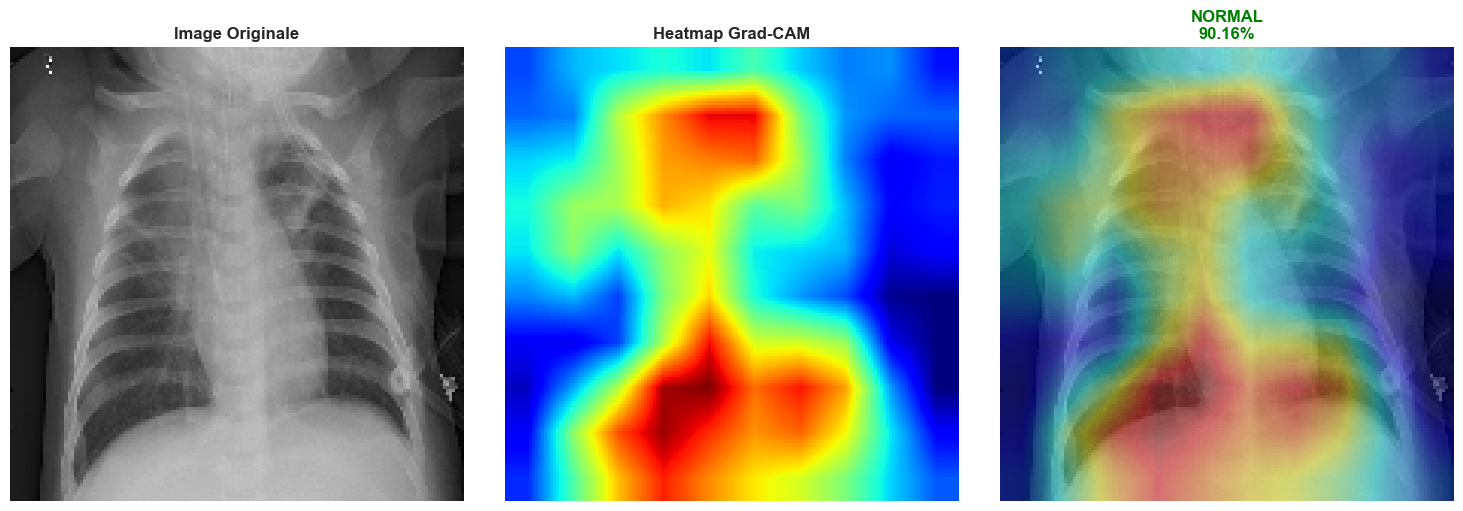


Image sauvegardee : models/gradcam_pneumonia.png


<Figure size 640x480 with 0 Axes>

In [94]:
print("=" * 60)
print("GRAD-CAM - IMAGE PNEUMONIA")
print("=" * 60)

test_image_pneumonia = 'C:/Users/Eya/Desktop/Projet Deep Learning/chest_xray/test/PNEUMONIA/person8_virus_27.jpeg'

if last_conv_custom:
    try:
        display_gradcam(test_image_pneumonia, model, last_conv_custom, img_size=(150, 150), is_rgb=False)
        
        # Sauvegarde
        plt.savefig(os.path.join(model_save_dir, 'gradcam_pneumonia.png'), dpi=300, bbox_inches='tight')
        print(f"\nImage sauvegardee : {model_save_dir}/gradcam_pneumonia.png")
    except Exception as e:
        print(f"ERREUR: {str(e)}")
else:
    print("ERREUR: Couche convolutionnelle non trouvee")

## TEST IMAGE NORMAL

GRAD-CAM - IMAGE NORMAL
Prediction : NORMAL (Confiance: 96.71%)


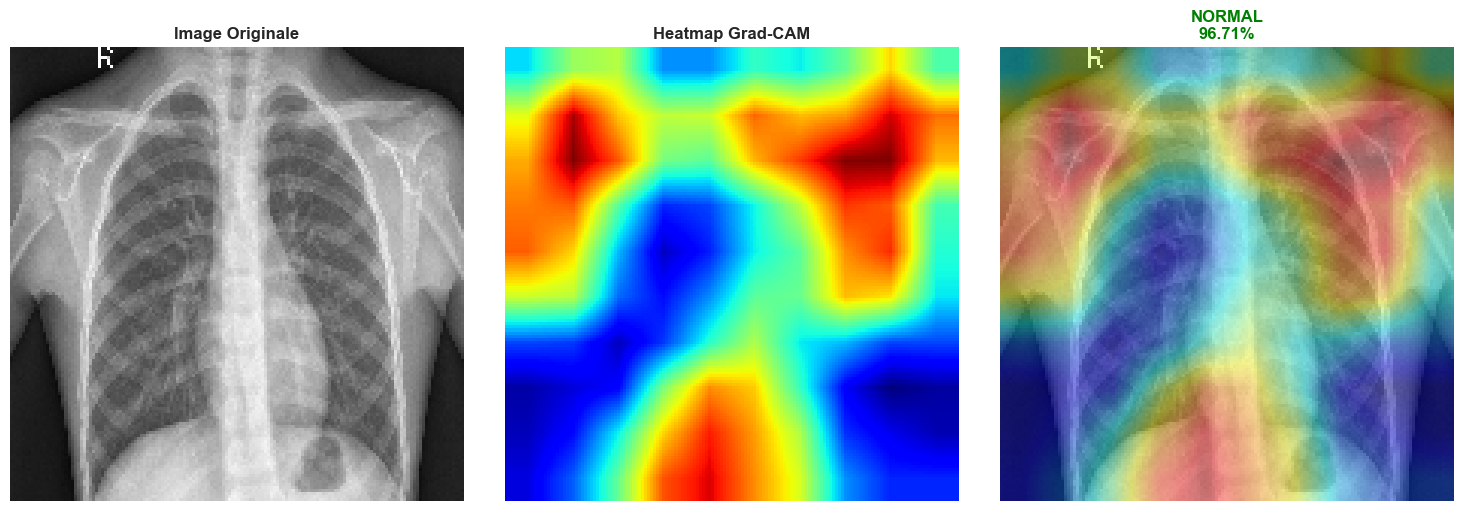


Image sauvegardee : models/gradcam_normal.png

GRAD-CAM TERMINE!


<Figure size 640x480 with 0 Axes>

In [96]:
print("=" * 60)
print("GRAD-CAM - IMAGE NORMAL")
print("=" * 60)

test_image_normal = 'C:/Users/Eya/Desktop/Projet Deep Learning/chest_xray/test/NORMAL/IM-0001-0001.jpeg'

if last_conv_custom:
    try:
        display_gradcam(test_image_normal, model, last_conv_custom, img_size=(150, 150), is_rgb=False)
        
        # Sauvegarde
        plt.savefig(os.path.join(model_save_dir, 'gradcam_normal.png'), dpi=300, bbox_inches='tight')
        print(f"\nImage sauvegardee : {model_save_dir}/gradcam_normal.png")
    except Exception as e:
        print(f"ERREUR: {str(e)}")
else:
    print("ERREUR: Couche convolutionnelle non trouvee")

print("\n" + "=" * 60)
print("GRAD-CAM TERMINE!")
print("=" * 60)